## Import Libraries

In [ ]:
import pandas as pd
from math import pi 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [103]:
df_final_sampled= pd.read_csv('./data/final_sampled_v2.csv', sep=';')
df_diary = pd.read_stata('./data/data4diarynew_ITA.dta')
df = df_final_sampled.copy()
df.social_date = pd.to_datetime(df.social_date)


In [104]:
df.shape

(208318, 44)

## Prepare user profile

### Step 1: Primary Sport Preference

In [105]:
# 1.1 Create activity dataframe from sport columns
sport_columns = [col for col in df.columns if col.startswith('sport_')]

# 1.2 For each user, count frequency of each sport
def get_primary_sport(user_df):
    sport_counts = {}
    for sport in sport_columns:
        sport_counts[sport] = user_df[sport].sum()
    
    # Return sport with highest count
    primary_sport = max(sport_counts, key=sport_counts.get)
    return primary_sport.replace('sport_', '')

# 1.3 Apply to each user
user_primary_sport = df.groupby('id').apply(get_primary_sport)

### Step 2: Activity Diversity Index (Shannon Entropy)

In [106]:
def calculate_activity_entropy(user_df):
    # Get total activity counts for each sport
    sport_counts = []
    for sport in sport_columns:
        count = user_df[sport].sum()
        if count > 0:
            sport_counts.append(count)
    
    if len(sport_counts) == 0:
        return 0
    
    # Calculate probabilities
    total_activities = sum(sport_counts)
    probabilities = [count/total_activities for count in sport_counts]
    
    # Calculate Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities if p > 0)
    
    # Normalize by max possible entropy (log of number of sports)
    max_entropy = np.log(len(sport_columns))
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
    return normalized_entropy

user_diversity_index = df.groupby('id').apply(calculate_activity_entropy)

### Step 3: Activity Intensity Classification

In [107]:
# 3.1 Map sports to intensity levels
intensity_mapping = {
    'sport_Walking, Trekking, and hiking': 'moderate',
    'sport_Jogging and running': 'high',
    'sport_Cycling, skiing, and skating': 'high',
    'sport_Ball games': 'high',
    'sport_Gymnastics and fitness': 'moderate',
    'sport_Water sports': 'moderate',
    'sport_Other indoor activities': 'low',
    'sport_Other outdoor activities': 'moderate'
}

# 3.2 Calculate weighted intensity score
def calculate_intensity_profile(user_df):
    intensity_scores = {'low_intensity': 0, 'moderate_intensity': 0, 'high_intensity': 0}
    
    for sport, intensity in intensity_mapping.items():
        activity_count = user_df[sport].sum()
        intensity_key = f'{intensity}_intensity'
        intensity_scores[intensity_key] += activity_count
    
    return pd.Series(intensity_scores)

# Apply function and create DataFrame
user_intensity_profile = df.groupby('id').apply(calculate_intensity_profile).reset_index()

# Rename the 'id' column if needed and ensure proper column names
user_intensity_profile.columns = ['id', 'low_intensity', 'moderate_intensity', 'high_intensity']


In [108]:
user_intensity_profile['total_activities'] = user_intensity_profile[['low_intensity', 'moderate_intensity', 'high_intensity']].sum(axis=1)

### Step 4: Walking Behaviour

=> steps per user on a daily basis

In [146]:
df_step = pd.read_csv('./data/stepdetectorevent.csv', sep=',')
df_step['day'] = pd.to_datetime(df_step['timestamp']).dt.date

In [ ]:
# 1. Aggregate total steps per user per day
steps_daily = df_step.groupby(['userid', 'day']).size().reset_index(name='steps')

# 2. Aggregate at user level
user_steps = steps_daily.groupby('userid').agg(
    total_steps=('steps', 'sum'),
    mean_steps=('steps', 'mean'),
    active_days=('day', 'count')
).reset_index()

# 3. Compute active_days_ratio
total_days = df_step['day'].nunique()

user_steps['active_days_ratio'] = user_steps['active_days'] / total_days



## Nutritional Profile

### Step 1: Average Daily Macronutrient Intake

In [ ]:
# 1.1 Define macronutrient columns
macronutrient_cols = ['energy_gain', 'protein_gain', 'fat_gain', 'carb_gain', 'fibre_gain']

# 1.2 Calculate daily aggregates
daily_nutrition = df.groupby(['id', 'social_date'])[macronutrient_cols].sum().reset_index()

# 1.3 Calculate user averages
def calculate_macro_profile(user_daily_df):
    macro_averages = user_daily_df[macronutrient_cols].mean()
    
    # Calculate macronutrient ratios
    total_energy = macro_averages['energy_gain']
    if total_energy > 0:
        macro_ratios = {
            'protein_ratio': (macro_averages['protein_gain'] * 4) / total_energy,
            'fat_ratio': (macro_averages['fat_gain'] * 9) / total_energy,
            'carb_ratio': (macro_averages['carb_gain'] * 4) / total_energy
        }
    else:
        macro_ratios = {'protein_ratio': 0, 'fat_ratio': 0, 'carb_ratio': 0}
    
    return {
        'avg_macros': macro_averages.to_dict(),
        'macro_ratios': macro_ratios
    }

user_macro_profile = daily_nutrition.groupby('id').apply(calculate_macro_profile)

In [ ]:
df_list = []
for key, value in user_macro_profile.items():
    row = {'id': key}
    # Flatten the nested structure
    for main_key, sub_dict in value.items():
        for sub_key, sub_value in sub_dict.items():
            row[f"{main_key}_{sub_key}"] = sub_value
    df_list.append(row)
user_macro_profile_df = pd.DataFrame(df_list)
user_macro_profile_df.set_index('id', inplace=True)



### Step 2: Meal Timing Patterns

In [ ]:
# 2.1 Classify meal times
def classify_meal_time(hour):
    if 5 <= hour < 10:
        return 'breakfast'
    elif 10 <= hour < 12:
        return 'morning_snack'
    elif 12 <= hour < 15:
        return 'lunch'
    elif 15 <= hour < 18:
        return 'afternoon_snack'
    elif 18 <= hour < 21:
        return 'dinner'
    else:
        return 'late_snack'
df['hour'] = pd.to_datetime(df.social_date).dt.hour
df['meal_type'] = df['hour'].apply(classify_meal_time)

# 2.2 Analyze meal timing patterns
def analyze_meal_timing(user_df):
    # Filter for records with actual food intake
    food_records = user_df[user_df['energy_gain'] > 0]
    
    if len(food_records) == 0:
        return pd.Series({
            'breakfast': 0,
            'morning_snack': 0,
            'lunch': 0,
            'afternoon_snack': 0,
            'dinner': 0,
            'late_snack': 0
        })
    
    # Count meals by type (normalized)
    meal_distribution = food_records['meal_type'].value_counts(normalize=True)
    
    # Create a complete series with all meal types
    all_meal_types = ['breakfast', 'morning_snack', 'lunch', 'afternoon_snack', 'dinner', 'late_snack']
    complete_distribution = pd.Series(0.0, index=all_meal_types)
    
    # Fill in the actual values
    for meal_type in meal_distribution.index:
        complete_distribution[meal_type] = meal_distribution[meal_type]
    
    # Calculate additional metrics
    complete_distribution['avg_eating_window'] = (
        food_records['hour'].max() - food_records['hour'].min() 
        if len(food_records) > 1 else 0
    )
    complete_distribution['total_eating_occasions'] = len(food_records)
    
    return complete_distribution

# Apply to each user and convert to DataFrame
user_meal_patterns = df.groupby('id').apply(analyze_meal_timing)


### Step 3: Nutrient Density Score Patterns

In [ ]:
# Nutrient Daily Values (DVs) from the table # https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels

# ---------- Configuration ----------
REF_ENERGY = 2000.0  

# Daily Values (DVs) from FDA 
DV = {
    # micronutrients 
    'protein_gain': 50.0,   # g/day
    'fibre_gain': 28.0,     # g/day
    'vitamin_A': 900.0,     # µg RAE / day
    'vitamin_B': 2.4,       # µg 
    'vitamin_C': 90.0,      # mg/day
    'calcium': 1300.0,      # mg/day
    'iron': 18.0,           # mg/day
    'potassium': 4700.0,    # mg/day
    'magnesium': 420.0,     # mg/day
    'phosphorus': 1250.0,   # mg/day
    'zinc': 11.0,           # mg/day
    'carb_gain': None,      
    'fat_gain': None        
}

# Define which nutrients are 'beneficial' and which are 'limiting'
beneficial = [
    'protein_gain','fibre_gain','vitamin_A','vitamin_B','vitamin_C',
    'calcium','iron','potassium','magnesium','phosphorus','zinc'
]

# limiting nutrients ideally: 'saturated_fat', 'added_sugar', 'sodium'
# we don't have them so we can leave limits empty (recommended rather than penalizing total fat/carb)
limiting = []  

weights_ben = {nut: 1.0 for nut in beneficial}
# weights for limiting nutrients
weights_lim = {nut: 1.0 for nut in limiting}

# ---------- helper functions ----------
def aggregate_daily(df, id_col='id', date_col='date', nutrient_cols=None):
    # sum nutrients and energy across the day for each user
    agg_dict = {c: 'sum' for c in nutrient_cols}
    agg = df.groupby([id_col, date_col]).agg(agg_dict).reset_index()
    return agg

def compute_energy_kcal(row):
    # if energy_gain column already contains kcal, use it; else compute
    if 'energy_gain' in row.index and not pd.isna(row['energy_gain']):
        return row['energy_gain']
    else:
        # compute from macros if present (carb_gain, protein_gain, fat_gain in grams)
        carb = row.get('carb_gain', 0.0) or 0.0
        protein = row.get('protein_gain', 0.0) or 0.0
        fat = row.get('fat_gain', 0.0) or 0.0
        return carb*4.0 + protein*4.0 + fat*9.0

def compute_nds_for_day(row, ref_energy=REF_ENERGY):
    """
    NRF-style energy-adjusted NDS for one aggregated day (row contains daily totals).
    Steps:
      - compute nutrient density per 1000 kcal for beneficial nutrients
      - convert DV/day -> DV per 1000 kcal: DV_per_1000 = DV * (1000 / ref_energy)
      - percentDV_density = (nutrient_per_1000 / DV_per_1000) * 100  (capped at 100)
      - sum weighted percentDV for beneficial nutrients
      - subtract weighted percentDV for limiting nutrients (if available)
      - scale final combined score to 0-100
    """
    energy_kcal = compute_energy_kcal(row)
    # guard against zero energy
    if energy_kcal <= 0:
        return np.nan

    # nutrient per 1000 kcal
    nutrient_per_1000 = {}
    for nut in beneficial:
        nutrient_total = row.get(nut, 0.0) or 0.0
        nutrient_per_1000[nut] = (nutrient_total / energy_kcal) * 1000.0

    # convert DV/day -> DV per 1000 kcal assuming ref_energy (2000 kcal)
    dv_per_1000 = {nut: (DV[nut] * (1000.0 / ref_energy)) for nut in beneficial}

    # percent of DV (density basis) capped at 100%
    percents = {}
    for nut in beneficial:
        dv1000 = dv_per_1000.get(nut)
        if dv1000 and dv1000 > 0:
            pct = (nutrient_per_1000[nut] / dv1000) * 100.0
            percents[nut] = min(pct, 100.0)
        else:
            percents[nut] = 0.0

    # Weighted sum for beneficial nutrients
    ben_score = sum(percents[nut] * weights_ben.get(nut, 1.0) for nut in beneficial)

    # limiting nutrients: compute percent of reference per 1000kcal and subtract (if available)
    lim_score = 0.0
    if limiting:
        # similar operations as above
        lim_percents = {}
        for nut in limiting:
            tot = row.get(nut, 0.0) or 0.0
            per1000 = (tot / energy_kcal) * 1000.0
            # you must supply DV for limiting nutrients if used
            dv_lim = DV.get(nut)
            if dv_lim and dv_lim > 0:
                dvlim1000 = dv_lim * (1000.0 / ref_energy)
                pct = min((per1000 / dvlim1000) * 100.0, 100.0)
                lim_percents[nut] = pct
            else:
                lim_percents[nut] = 0.0
        lim_score = sum(lim_percents[nut] * weights_lim.get(nut, 1.0) for nut in limiting)

    # Combine (NRF often computes: sum(benefit) - sum(limit))
    raw_score = ben_score - lim_score

    # Optional: rescale raw_score to a 0-100 range for interpretability.
    # A simple approach: compute the maximum possible ben_score (all percents = 100)
    max_ben = sum(100.0 * weights_ben.get(nut, 1.0) for nut in beneficial)
    max_lim = sum(100.0 * weights_lim.get(nut, 1.0) for nut in limiting) if limiting else 0.0
    # raw_score ranges roughly from -max_lim .. max_ben. We'll map that to 0..100.
    min_raw = -max_lim
    max_raw = max_ben

    # avoid divide by zero
    if max_raw - min_raw == 0:
        scaled = np.nan
    else:
        scaled = (raw_score - min_raw) / (max_raw - min_raw) * 100.0
        scaled = max(0.0, min(100.0, scaled))

    return scaled

# ---------- Putting it together ----------
def compute_user_daily_nds(df, id_col='id', date_col='date'):
    # ensure date col is date type
    df[date_col] = pd.to_datetime(df[date_col]).dt.date

    nutrient_cols = list(beneficial) + ['carb_gain', 'fat_gain', 'energy_gain']
    # aggregate daily totals
    daily = aggregate_daily(df, id_col=id_col, date_col=date_col, nutrient_cols=nutrient_cols)

    # compute energy_kcal column if not present
    if 'energy_gain' not in daily.columns or daily['energy_gain'].isna().all():
        # compute from macros in grams
        daily['energy_gain'] = daily['carb_gain'].fillna(0)*4 + daily['protein_gain'].fillna(0)*4 + daily['fat_gain'].fillna(0)*9

    # compute NDS per day
    daily['NDS_daily'] = daily.apply(lambda r: compute_nds_for_day(r), axis=1)

    # then average across days for each user to get habitual NDS
    user_nds = daily.groupby(id_col)['NDS_daily'].mean().reset_index().rename(columns={'NDS_daily':'NDS_user_mean'})

    return daily, user_nds




In [ ]:
daily_summary, user_profiles = compute_user_daily_nds(df, id_col='id', date_col='social_date')


In [ ]:
daily_summary.isna().sum()

id                0
social_date       0
protein_gain      0
fibre_gain        0
vitamin_A         0
vitamin_B         0
vitamin_C         0
calcium           0
iron              0
potassium         0
magnesium         0
phosphorus        0
zinc              0
carb_gain         0
fat_gain          0
energy_gain       0
NDS_daily       524
dtype: int64

In [ ]:
daily_summary.to_csv('./data/daily_nutrition_summary.csv', sep=';', index=False)

In [ ]:
daily_summary.head()

,id,social_date,protein_gain,fibre_gain,vitamin_A,vitamin_B,vitamin_C,calcium,iron,potassium,magnesium,phosphorus,zinc,carb_gain,fat_gain,energy_gain,NDS_daily
0,0.0,2020-11-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,0.0,2020-11-13,61.400000,65.000000,542.000000,899.500000,20.500000,612.500000,19.250000,4402.0,613.500000,1276.500000,8.140000,322.050000,78.650000,2371.500000,75.222004
2,0.0,2020-11-14,73.439070,57.401163,159.500000,166.500000,14.000000,645.837209,14.850233,3518.0,437.500000,959.000000,6.385000,226.656977,85.506977,2153.104651,67.742157
3,0.0,2020-11-15,93.020000,122.600000,359.000000,411.000000,9.100000,849.500000,30.205000,7128.5,869.000000,1559.000000,9.955000,273.050000,161.750000,3161.500000,73.188007
4,0.0,2020-11-16,64.968182,129.063636,75.409091,90.340909,25.931818,574.704545,25.461364,7137.5,907.295455,1104.068182,6.294091,250.847727,88.220455,2317.613636,72.349381


### Step 4: Dietary Quality and Consistency

In [ ]:

DV = {
    'protein_gain': 50.0, 'fibre_gain': 28.0, 'vitamin_A': 900.0,
    'vitamin_B': 2.4, 'vitamin_C': 90.0,
    'calcium': 1300.0, 'iron': 18.0, 'potassium': 4700.0,
    'magnesium': 420.0, 'phosphorus': 1250.0, 'zinc': 11.0
}

def simple_nds_from_totals_row(row, dv_map=DV):
    """Simple percent-of-DV based NDS (0-100). Use only if NDS_daily is missing."""
    parts = []
    for nut, dv in dv_map.items():
        val = row.get(nut, 0.0) or 0.0
        pct = (val / dv) * 100.0 if dv > 0 else 0.0
        parts.append(min(pct, 100.0))
    raw = sum(parts)
    max_raw = 100.0 * len(dv_map)
    if max_raw == 0:
        return np.nan
    scaled = (raw / max_raw) * 100.0
    return float(np.clip(scaled, 0.0, 100.0))

# ---------------------
# Main function (per-user)
# ---------------------
def calculate_dietary_consistency_nds(user_df,
                                      date_col='social_date',
                                      nds_col='NDS_daily',
                                      nutrient_cols=None):
    """
    Calculate consistency metrics for one user's dataframe (many dates).
    - user_df: DataFrame for a single user (multiple dates)
    - date_col: column with date (can be datetime.date or string)
    - nds_col: name of column with daily NDS. If missing, function will try to compute it from nutrient_cols or DV map.
    - nutrient_cols: optional list of nutrient columns to include in CV calculations (e.g., ['protein_gain','fibre_gain'])
    Returns: dict or None (if <3 days)
    """
    # Ensure date col is date-like
    df = user_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        try:
            df[date_col] = pd.to_datetime(df[date_col])
        except Exception:
            pass

    # Build daily aggregates (sum across the date in case there are multiple records per date)
    # If date contains time, group by date only
    if pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df['_date_only'] = pd.to_datetime(df[date_col]).dt.date
        group_col = '_date_only'
    else:
        df['_date_only'] = df[date_col]
        group_col = '_date_only'

    # If nutrient_cols provided, aggregate them; otherwise aggregate all numeric columns (safe fallback)
    if nutrient_cols is None:
        # exclude non-numeric and known meta cols
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        # prefer DV nutrients if present
        nutrient_cols = [c for c in numeric_cols if c not in ['id']]  # keep id out
    # Always keep nds_col if present
    agg_cols = list(set(nutrient_cols + ([nds_col] if nds_col in df.columns else [])))
    agg_dict = {c: 'sum' for c in agg_cols if c in df.columns}

    if len(agg_dict) == 0:
        return None

    daily = df.groupby(group_col).agg(agg_dict).reset_index().rename(columns={group_col: 'social_date'})

    # If NDS_daily missing, compute from totals using helper
    if nds_col not in daily.columns:
        daily[nds_col] = daily.apply(simple_nds_from_totals_row, axis=1)

    # Need minimum days for meaningful CV
    if len(daily) < 3:
        return None

    # Compute CVs for requested columns: include NDS first
    consistency_scores = {}
    def safe_cv(series):
        m = series.mean()
        s = series.std()
        if m == 0 or np.isnan(m):
            return np.inf
        return s / m

    # NDS CV
    consistency_scores[f'{nds_col}_cv'] = safe_cv(daily[nds_col])

    # nutrient CVs (if provided and present)
    for col in nutrient_cols:
        if col in daily.columns:
            consistency_scores[f'{col}_cv'] = safe_cv(daily[col])

    # Overall consistency: mean of CVs (lower better)
    # ignore infinite CVs when computing mean (but keep note)
    finite_vals = [v for v in consistency_scores.values() if np.isfinite(v)]
    if len(finite_vals) == 0:
        overall_consistency = np.inf
    else:
        overall_consistency = float(np.mean(finite_vals))

    # Classify consistency 
    if overall_consistency < 0.2:
        consistency_category = 'very_consistent'
    elif overall_consistency < 0.4:
        consistency_category = 'consistent'
    elif overall_consistency < 0.6:
        consistency_category = 'moderate'
    else:
        consistency_category = 'inconsistent'

    return {
        'nutrient_cvs': consistency_scores,
        'overall_consistency': overall_consistency,
        'consistency_category': consistency_category,
        'days_used': int(len(daily))
    }
# ---------------------
# Apply to all users: returns Series of dicts 
# ---------------------

def compute_all_users_consistency(df, id_col='id', **kwargs):
    """
    Compute the consistency dict for each user and return a DataFrame.
    kwargs passed to calculate_dietary_consistency_nds (e.g., nds_col, nutrient_cols)
    """
    grouped = df.groupby(id_col).apply(lambda g: calculate_dietary_consistency_nds(g, **kwargs))
    # grouped is a Series indexed by user id containing dicts or None
    rows = []
    for uid, val in grouped.items():
        if val is None:
            rows.append({'id': uid, 'days_used': 0, 'overall_consistency': np.nan, 'consistency_category': None})
            continue
        # flatten nutrient cvs
        row = {'id': uid, 'days_used': val.get('days_used', np.nan),
               'overall_consistency': val.get('overall_consistency'),
               'consistency_category': val.get('consistency_category')}
        # add individual CVs
        for k, v in val.get('nutrient_cvs', {}).items():
            row[k] = v
        rows.append(row)
    return pd.DataFrame(rows)




In [ ]:

consistency_df = compute_all_users_consistency(df, id_col='id', nds_col='NDS_daily',
                                               nutrient_cols=['protein_gain','fibre_gain','carb_gain','fat_gain'])
# consistency_df.head()

## Sleep-Activity Profile

### Step 1: Filter Users with Sleep Data

In [ ]:
df.head(10)

,id,date_time,social_date,mood,sleep,energy_gain,water_gain,protein_gain,fat_gain,carb_gain,...,department,cohort,degree,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,hour,meal_type
0,0.0,Evening,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,19,dinner
1,0.0,Evening,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,19,dinner
2,0.0,Night Time,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,20,dinner
3,0.0,Night Time,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,20,dinner
4,0.0,Night Time,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,21,late_snack
5,0.0,Night Time,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,21,late_snack
6,0.0,Mid Night,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,22,late_snack
7,0.0,Mid Night,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,22,late_snack
8,0.0,Mid Night,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,23,late_snack
9,0.0,Mid Night,2020-11-12,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,23,late_snack


In [ ]:
def process_sleep_imputation(df):
    # Convert date to datetime if not already
    df['social_date'] = pd.to_datetime(df['social_date'])
    df['day'] = df['social_date'].dt.date

    # Helper function to process each ID group
    def process_id_group(group):
        # Group by day and take the mean sleep value for each day
        daily_sleep = group.groupby('day')['sleep'].mean()
        
        # Create date range for this specific ID
        all_days = pd.date_range(start=group['day'].min(), end=group['day'].max(), freq='D').date
        
        # Reindex to all days in range and interpolate missing values
        sleep_series = daily_sleep.reindex(all_days)
        sleep_series_interpolated = sleep_series.interpolate(method='linear', limit_direction='both')
        
        # Map interpolated values back to original group
        group['sleep_filled'] = group['day'].map(sleep_series_interpolated)
        return group

    # Apply processing to each ID group
    df = df.groupby('id').apply(process_id_group).reset_index(drop=True)
    return df['sleep_filled']

In [ ]:
df['sleep_2'] = process_sleep_imputation(df)

In [ ]:
# 1.1 Identify users with sufficient sleep data
sleep_data_users = df[df['sleep'].notna()].groupby('id').size()
valid_sleep_users = sleep_data_users[sleep_data_users >= 7].index  # At least 7 days

# 1.2 Create sleep-focused dataset
sleep_df = df[df['id'].isin(valid_sleep_users)].copy()

In [ ]:
sleep_df.id.nunique()

146

### Step 2: Average Sleep Quality & Variability

In [ ]:
def analyze_sleep_quality(user_df):
    sleep_records = user_df[user_df['sleep'].notna()]
    
    if len(sleep_records) < 3:
        return None
    
    sleep_stats = {
        'avg_sleep_quality': sleep_records['sleep'].mean(),
        'sleep_std': sleep_records['sleep'].std(),
        'sleep_cv': sleep_records['sleep'].std() / sleep_records['sleep'].mean(),
        'min_sleep': sleep_records['sleep'].min(),
        'max_sleep': sleep_records['sleep'].max(),
        'sleep_range': sleep_records['sleep'].max() - sleep_records['sleep'].min()
    }
    
    # Classify sleep quality
    if sleep_stats['avg_sleep_quality'] >= 5:
        sleep_category = 'excellent'
    elif sleep_stats['avg_sleep_quality'] >= 4:
        sleep_category = 'good'
    elif sleep_stats['avg_sleep_quality'] >= 2:
        sleep_category = 'fair'
    else:
        sleep_category = 'poor'
    
    sleep_stats['sleep_category'] = sleep_category
    
    return sleep_stats

user_sleep_quality = sleep_df.groupby('id').apply(analyze_sleep_quality)

In [ ]:
df_list = []
for key, value in user_sleep_quality.items():
    row = {'id': key}
    # Check if value is a dictionary
    if isinstance(value, dict):
        # Flatten the dictionary structure
        for sub_key, sub_value in value.items():
            row[sub_key] = sub_value
    else:
        # Handle non-dictionary values
        row['value'] = value
    df_list.append(row)
user_sleep_quality_df = pd.DataFrame(df_list)
user_sleep_quality_df.set_index('id', inplace=True)


## Final Step: Combine All Profiles into Master User Profile

In [ ]:
user_profile_df = user_primary_sport.reset_index(name='primary_sport').copy()
user_profile_df = pd.merge(user_profile_df, user_diversity_index.rename('diversity_index'), left_on='id', right_index=True, how='left')
user_profile_df = pd.merge(user_profile_df, user_intensity_profile, left_on='id', right_on='id', how='left')
# user_profile_df = pd.merge(user_profile_df, user_steps.rename(columns={'userid':'id'}), left_on='id', right_on='id', how='left')
user_profile_df = pd.merge(user_profile_df, user_macro_profile_df, left_on='id', right_on='id', how='left')
user_profile_df = pd.merge(user_profile_df, user_meal_patterns, left_on='id', right_on='id', how='left')
user_profile_df = pd.merge(user_profile_df, user_profiles, left_on='id', right_on='id', how='left')
user_profile_df = pd.merge(user_profile_df, consistency_df, left_on='id', right_on='id', how='left')
user_profile_df = pd.merge(user_profile_df, user_sleep_quality_df, left_on='id', right_on='id', how='left')



In [ ]:
user_profile_df.head(10)

,id,primary_sport,diversity_index,low_intensity,moderate_intensity,high_intensity,total_activities,avg_macros_energy_gain,avg_macros_protein_gain,avg_macros_fat_gain,...,fibre_gain_cv,carb_gain_cv,fat_gain_cv,avg_sleep_quality,sleep_std,sleep_cv,min_sleep,max_sleep,sleep_range,sleep_category
0,0.0,Other outdoor activities,-0.000000,0,2,0,2,38.777177,1.296259,1.147191,...,0.695367,0.562787,0.961173,4.217391,1.126399,0.267084,1.0,5.0,4.0,good
1,1.0,Other indoor activities,0.255930,3,1,0,4,44.513383,1.291425,1.652310,...,0.877537,0.473701,0.760258,3.523810,0.511766,0.145231,3.0,4.0,1.0,fair
2,3.0,"Walking, Trekking, and hiking",0.000000,0,0,0,0,29.482533,1.053197,0.867946,...,0.934062,0.742222,0.844284,3.954545,0.722250,0.182638,2.0,5.0,3.0,fair
3,4.0,Gymnastics and fitness,-0.000000,0,25,0,25,31.425686,1.014202,0.619736,...,0.574113,0.422449,0.811097,4.142857,0.448395,0.108233,3.0,5.0,2.0,good
4,5.0,Gymnastics and fitness,0.457050,3,3,1,7,53.472397,1.905744,1.924855,...,0.595772,0.437723,0.566141,3.857143,0.573212,0.148610,2.0,5.0,3.0,fair
5,6.0,Gymnastics and fitness,0.272284,2,5,0,7,41.507557,1.489627,0.967390,...,0.647912,0.524702,0.734754,3.925926,0.474417,0.120842,3.0,5.0,2.0,fair
6,8.0,"Walking, Trekking, and hiking",0.000000,0,0,0,0,62.811817,2.052620,1.667276,...,0.406458,0.547477,0.483658,4.071429,0.377964,0.092833,3.0,5.0,2.0,good
7,9.0,Gymnastics and fitness,-0.000000,0,8,0,8,68.139842,2.086314,2.158231,...,0.462686,0.385650,0.462683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12.0,Gymnastics and fitness,0.306301,0,5,0,5,35.403758,0.981312,1.399905,...,0.906047,0.690847,0.791136,4.190476,1.249762,0.298239,1.0,5.0,4.0,good
9,13.0,"Walking, Trekking, and hiking",0.000000,0,0,0,0,22.071507,0.708375,0.749111,...,1.004147,0.945148,0.912551,3.863636,0.351250,0.090912,3.0,4.0,1.0,fair


## User Profile Clustering

## Map Categorical Variables

In [ ]:
obj_cols = user_profile_df.select_dtypes(include=[object]).columns

In [ ]:
user_profile_df[obj_cols]

consistency_dict = {'inconsistent': 0, 'moderate': 1, 'consistent': 2}
sleep_dict = {'poor': 0, 'fair': 1, 'good': 2}
sport_dict = {
    'Other indoor activities': 1,
    'Other outdoor activities': 2,
    'Walking, Trekking, and hiking': 3,
    'Jogging and running': 4,
    'Cycling, skiing, and skating': 5,
    'Ball games': 6,
    'Gymnastics and fitness': 7,
    'Water sports': 8,
}

user_profile_df['consistency_category'] = user_profile_df['consistency_category'].map(consistency_dict)
user_profile_df['sleep_category'] = user_profile_df['sleep_category'].map(sleep_dict)
user_profile_df['primary_sport'] = user_profile_df['primary_sport'].map(sport_dict)


=== FEATURE STATISTICS ===
       primary_sport  diversity_index  low_intensity  moderate_intensity  \
count     187.000000       187.000000     187.000000          187.000000   
mean        4.251337         0.094511       1.192513            6.096257   
std         2.113941         0.165418       4.875366           10.711331   
min         1.000000         0.000000       0.000000            0.000000   
25%         3.000000        -0.000000       0.000000            0.000000   
50%         3.000000         0.000000       0.000000            1.000000   
75%         7.000000         0.183434       0.000000            8.000000   
max         8.000000         0.637072      53.000000           54.000000   

       high_intensity  total_activities  avg_macros_energy_gain  \
count      187.000000        187.000000              187.000000   
mean         1.502674          8.791444               36.440078   
std          4.262079         12.468642               16.708688   
min          0.00000

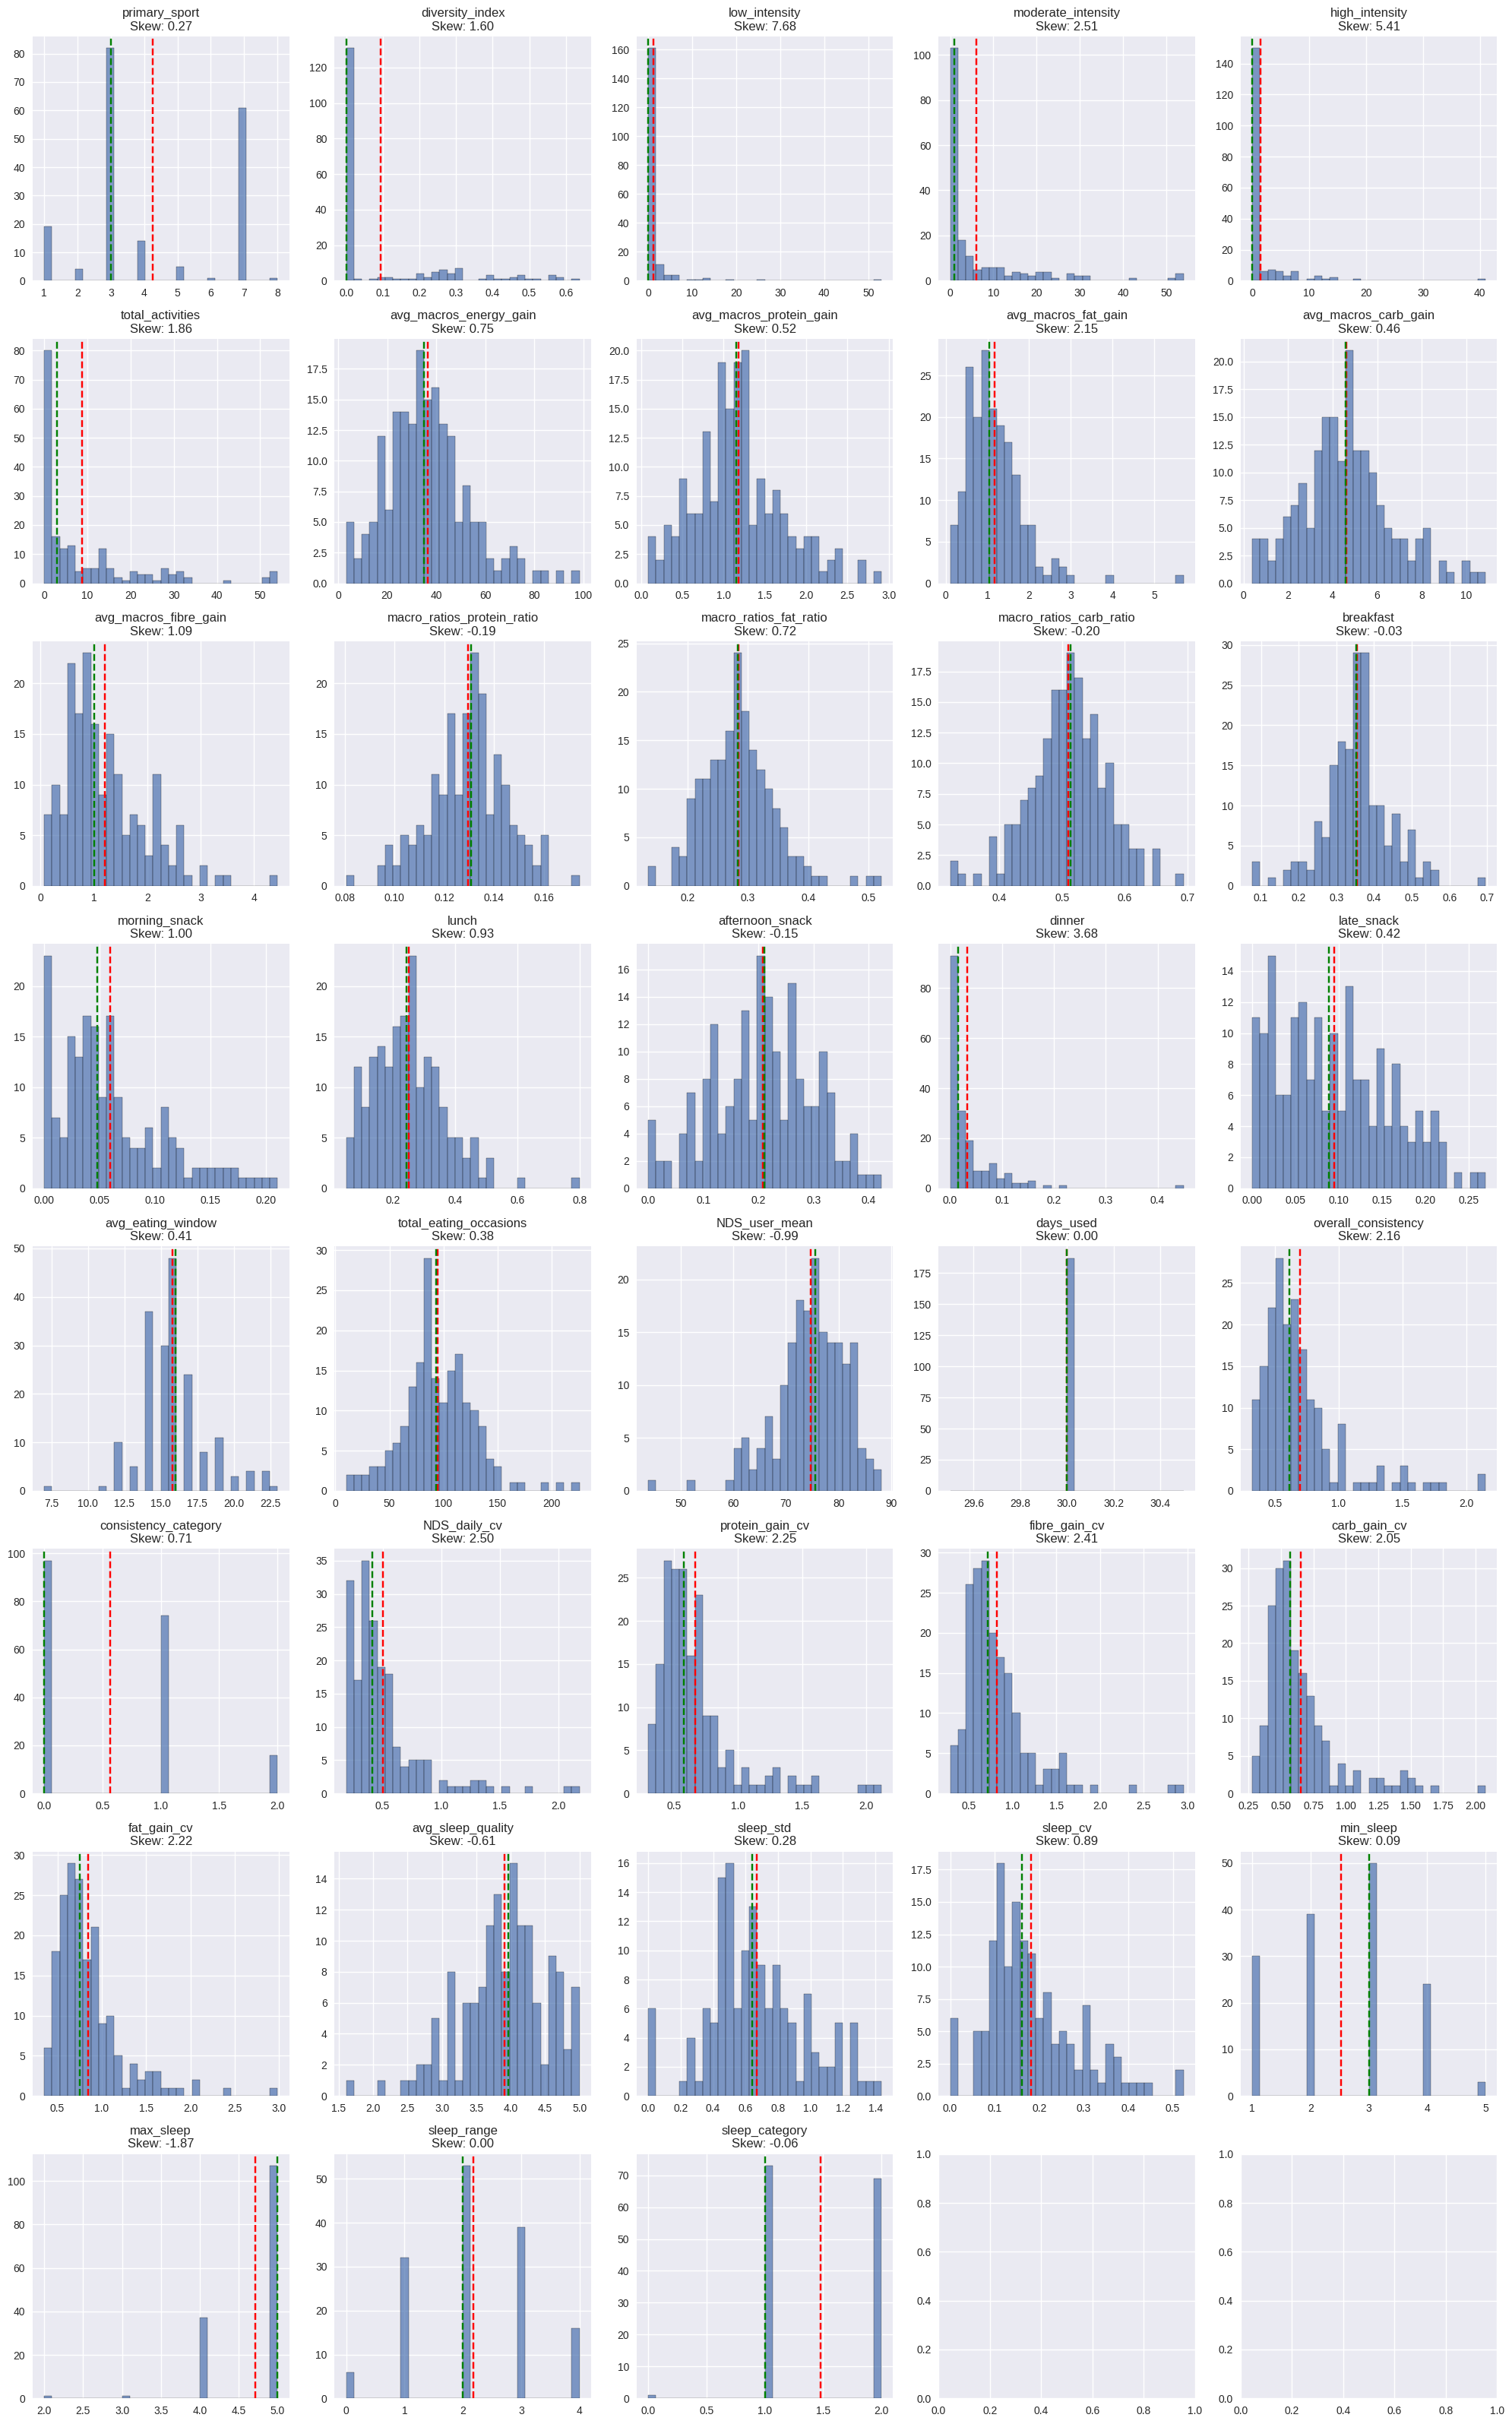

In [ ]:

def analyze_feature_distributions(df_clustering_features):
    """
    Analyze distributions and identify preprocessing needs
    """
    features = df_clustering_features.drop('id', axis=1)
    features = features.select_dtypes(include=[np.number])  # Keep only numeric
    
    # Check for issues
    print("=== FEATURE STATISTICS ===")
    print(features.describe())
    
    print("\n=== SKEWNESS ===")
    skewness = features.skew()
    print(skewness[abs(skewness) > 1])  # Highly skewed features
    
    print("\n=== COEFFICIENT OF VARIATION ===")
    cv = features.std() / features.mean()
    print(cv.sort_values(ascending=False))
    
    # Calculate grid dimensions for subplots based on number of features
    n_features = len(features.columns)
    n_cols = 5
    n_rows = (n_features // n_cols) + (1 if n_features % n_cols > 0 else 0)

    # Visualize distributions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(features.columns):
        axes[idx].hist(features[col], bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}\nSkew: {features[col].skew():.2f}')
        axes[idx].axvline(features[col].mean(), color='red', linestyle='--', label='Mean')
        axes[idx].axvline(features[col].median(), color='green', linestyle='--', label='Median')
    
    plt.tight_layout()
    plt.show()
    
    return features

# Run analysis
features = analyze_feature_distributions(user_profile_df)

### Perform Clustering

### Remove Sleep Features

In [ ]:
sleep_features = ['avg_sleep_quality', 'sleep_std', 'sleep_cv', 'min_sleep', 'max_sleep', 'sleep_range', 'sleep_category']


In [ ]:
user_profile_df_notna = user_profile_df.dropna(axis=0).copy()
user_profile_df_notna.drop(columns=sleep_features, errors='ignore', inplace=True)
user_profile_df_notna.drop(columns=obj_cols, errors='ignore', inplace=True)



In [ ]:

def preprocess_for_clustering(df):
    # 1. Drop non-informative features
    df_clean = df.drop(['id', 'days_used'], axis=1)
    
    # 2. Handle missing values if any
    df_clean = df_clean.fillna(df_clean.mean())
    
    # 3. Remove one feature from each sum-to-one group
    df_clean = df_clean.drop(['late_snack', 'carb_ratio'], axis=1)
    
    # 4. Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean)
    
    
    return reduced_data, scaler, pca

# Apply preprocessing
processed_data, scaler, pca = preprocess_for_clustering(df)

In [ ]:
def perform_comprehensive_clustering(features_df):
    """
    Apply multiple clustering methods and compare
    """
    
    
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df.drop('id', axis=1))
    
    # Method 1: K-Means
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_features)
     
    # Method 2: Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=3)
    hier_labels = hierarchical.fit_predict(scaled_features)
    
    # Method 3: Gaussian Mixture Model
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm_labels = gmm.fit_predict(scaled_features)
    
    # Method 4: DBSCAN (density-based)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_features)
    
    return {
        'kmeans': kmeans_labels,
        'hierarchical': hier_labels,
        'gmm': gmm_labels,
        'dbscan': dbscan_labels
    }

In [133]:
clusters = perform_comprehensive_clustering(user_profile_df_notna)

In [134]:
df_clustering_features = user_profile_df_notna.copy()

In [135]:
df_clustering_features[['PCA1', 'PCA2']] = PCA(n_components=2).fit_transform(df_clustering_features.drop(columns=['id']))

## Selecting the best Cluster

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


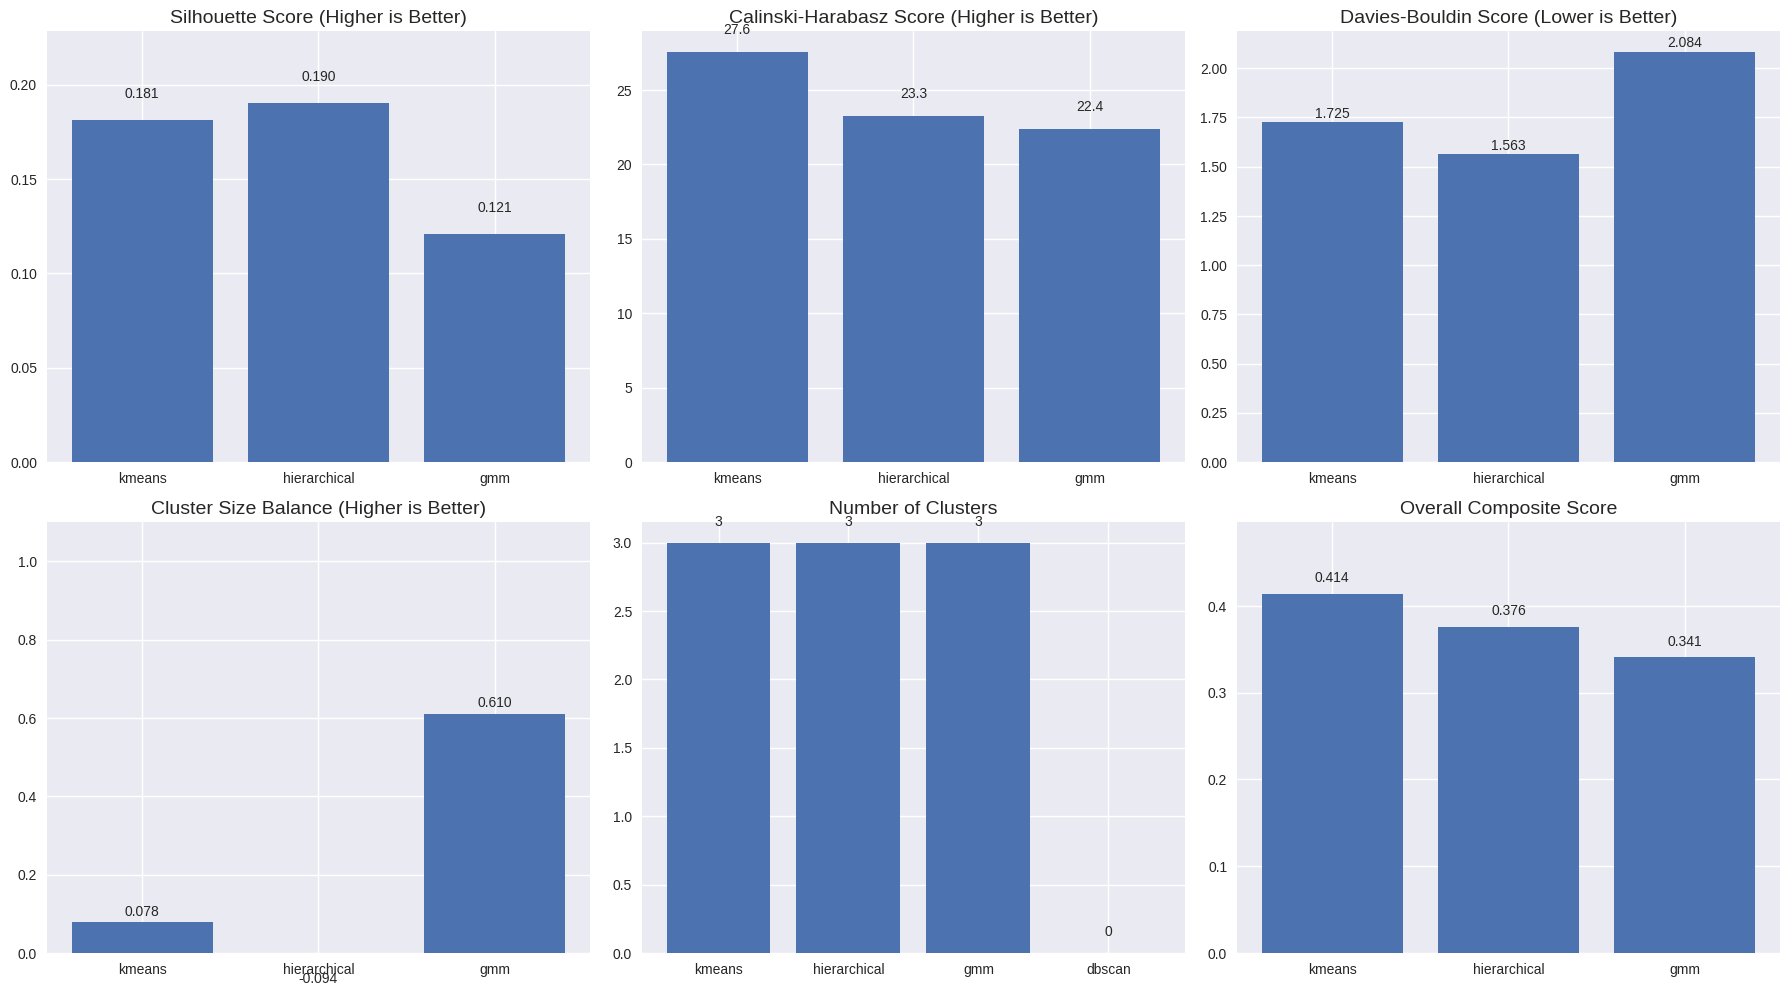


=== CLUSTERING EVALUATION SUMMARY ===

KMEANS:
  - Silhouette Score: 0.181
  - Size Balance: 0.078
  - Cluster Sizes: {0: 17, 1: 98, 2: 28}

HIERARCHICAL:
  - Silhouette Score: 0.190
  - Size Balance: -0.094
  - Cluster Sizes: {0: 105, 1: 35, 2: 3}

GMM:
  - Silhouette Score: 0.121
  - Size Balance: 0.610
  - Cluster Sizes: {0: 27, 1: 63, 2: 53}

DBSCAN:
  - Silhouette Score: nan
  - Size Balance: nan
  - Cluster Sizes: {-1: 143}



In [ ]:
def evaluate_clustering_methods(df_clustering_features, clusters_dict):
    """
    Evaluate all clustering methods using multiple metrics
    """
    # Prepare features (exclude id)
    features = df_clustering_features.drop('id', axis=1)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Initialize results dictionary
    evaluation_results = {}
    
    for method_name, labels in clusters_dict.items():
        # Skip DBSCAN if it has -1 labels (noise points)
        if -1 in labels:
            n_clusters = len(set(labels)) - 1
            n_noise = list(labels).count(-1)
        else:
            n_clusters = len(set(labels))
            n_noise = 0
        
        # Calculate metrics
        if n_clusters > 1:  # Need at least 2 clusters for these metrics
            silhouette = silhouette_score(features_scaled, labels)
            calinski = calinski_harabasz_score(features_scaled, labels)
            davies_bouldin = davies_bouldin_score(features_scaled, labels)
        else:
            silhouette = calinski = davies_bouldin = np.nan
        
        # Calculate cluster sizes
        cluster_sizes = pd.Series(labels).value_counts().sort_index()
        size_std = cluster_sizes.std()
        size_balance = 1 - (size_std / cluster_sizes.mean())  # Higher is better
        
        evaluation_results[method_name] = {
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski,
            'davies_bouldin_score': davies_bouldin,  # Lower is better
            'size_balance': size_balance,
            'min_cluster_size': cluster_sizes.min(),
            'max_cluster_size': cluster_sizes.max(),
            'cluster_sizes': cluster_sizes.to_dict()
        }
    
    return evaluation_results

# Run evaluation
evaluation_results = evaluate_clustering_methods(df_clustering_features, clusters)

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Silhouette Scores
ax = axes[0, 0]
methods = list(evaluation_results.keys())
silhouette_scores = [evaluation_results[m]['silhouette_score'] for m in methods]
bars = ax.bar(methods, silhouette_scores)
ax.set_title('Silhouette Score (Higher is Better)', fontsize=14)
ax.set_ylim(0, max(silhouette_scores) * 1.2)
for bar, score in zip(bars, silhouette_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom')

# 2. Calinski-Harabasz Scores
ax = axes[0, 1]
ch_scores = [evaluation_results[m]['calinski_harabasz_score'] for m in methods]
bars = ax.bar(methods, ch_scores)
ax.set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=14)
for bar, score in zip(bars, ch_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{score:.1f}', ha='center', va='bottom', rotation=0)

# 3. Davies-Bouldin Scores
ax = axes[0, 2]
db_scores = [evaluation_results[m]['davies_bouldin_score'] for m in methods]
bars = ax.bar(methods, db_scores)
ax.set_title('Davies-Bouldin Score (Lower is Better)', fontsize=14)
for bar, score in zip(bars, db_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom')

# 4. Cluster Size Balance
ax = axes[1, 0]
balance_scores = [evaluation_results[m]['size_balance'] for m in methods]
bars = ax.bar(methods, balance_scores)
ax.set_title('Cluster Size Balance (Higher is Better)', fontsize=14)
ax.set_ylim(0, 1.1)
for bar, score in zip(bars, balance_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom')

# 5. Number of Clusters
ax = axes[1, 1]
n_clusters = [evaluation_results[m]['n_clusters'] for m in methods]
bars = ax.bar(methods, n_clusters)
ax.set_title('Number of Clusters', fontsize=14)
for bar, n in zip(bars, n_clusters):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{n}', ha='center', va='bottom')

# 6. Overall Score (normalized composite)
ax = axes[1, 2]
# Calculate composite score
composite_scores = []
for m in methods:
    # Normalize scores to 0-1 range
    sil = evaluation_results[m]['silhouette_score']
    ch = evaluation_results[m]['calinski_harabasz_score'] / max(ch_scores)
    db = 1 - (evaluation_results[m]['davies_bouldin_score'] / max(db_scores))  # Invert
    bal = evaluation_results[m]['size_balance']
    
    # Weighted composite (adjust weights as needed)
    composite = 0.3*sil + 0.3*ch + 0.3*db + 0.1*bal
    composite_scores.append(composite)

bars = ax.bar(methods, composite_scores)
ax.set_title('Overall Composite Score', fontsize=14)
ax.set_ylim(0, max(composite_scores) * 1.2)
for bar, score in zip(bars, composite_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n=== CLUSTERING EVALUATION SUMMARY ===\n")
for method, results in evaluation_results.items():
    print(f"{method.upper()}:")
    print(f"  - Silhouette Score: {results['silhouette_score']:.3f}")
    print(f"  - Size Balance: {results['size_balance']:.3f}")
    print(f"  - Cluster Sizes: {results['cluster_sizes']}")
    print()

In [ ]:
def test_clustering_stability(df_clustering_features, n_iterations=10):
    """
    Test stability of clustering methods using bootstrap sampling
    """
    
    features = df_clustering_features.drop('id', axis=1)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    stability_results = {method: [] for method in ['kmeans', 'hierarchical', 'gmm']}
    
    for iteration in range(n_iterations):
        # Bootstrap sample
        indices = np.random.choice(len(features_scaled), size=len(features_scaled), replace=True)
        features_boot = features_scaled[indices]
        
        
        
        # K-means
        kmeans = KMeans(n_clusters=5, random_state=iteration)
        labels_kmeans = kmeans.fit_predict(features_boot)
        
        # Hierarchical
        hier = AgglomerativeClustering(n_clusters=5)
        labels_hier = hier.fit_predict(features_boot)
        
        # GMM
        gmm = GaussianMixture(n_components=5, random_state=iteration)
        labels_gmm = gmm.fit_predict(features_boot)
        
        # Compare with original clustering on same indices
        if iteration > 0:  # Compare with first iteration
            stability_results['kmeans'].append(
                adjusted_rand_score(base_kmeans[indices], labels_kmeans))
            stability_results['hierarchical'].append(
                adjusted_rand_score(base_hier[indices], labels_hier))
            stability_results['gmm'].append(
                adjusted_rand_score(base_gmm[indices], labels_gmm))
        else:
            base_kmeans = labels_kmeans
            base_hier = labels_hier
            base_gmm = labels_gmm
    
    # Plot stability results
    plt.figure(figsize=(10, 6))
    positions = [1, 2, 3]
    labels = ['K-means', 'Hierarchical', 'GMM']
    
    plt.boxplot([stability_results['kmeans'], 
                 stability_results['hierarchical'], 
                 stability_results['gmm']], 
                positions=positions, labels=labels)
    
    plt.ylabel('Adjusted Rand Score')

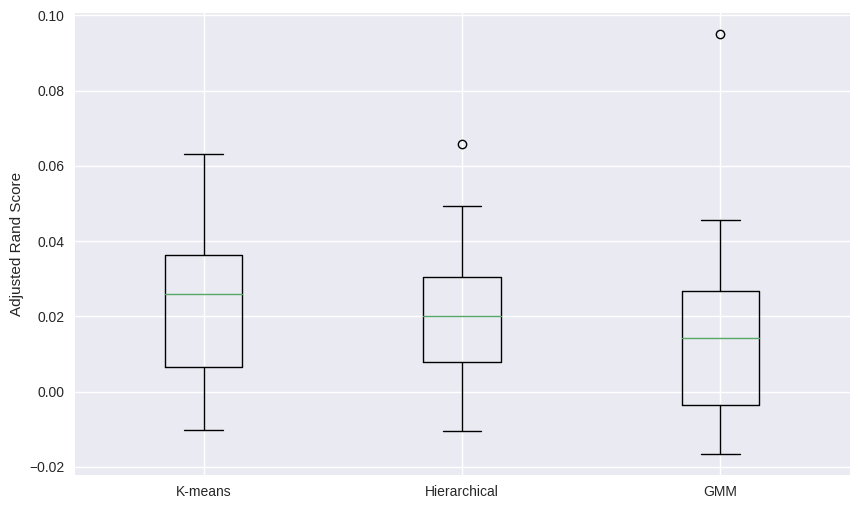

In [138]:
test_clustering_stability(df_clustering_features, n_iterations=20)

In [139]:
def plot_clustering_results(cluster_name, clusters, df_clustering_features):
    # Create comprehensive cluster visualization
    
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    cluster_labels = clusters[cluster_name]['labels'] if 'labels' in clusters[cluster_name] else clusters[cluster_name]

    # 1. PCA Visualization with Clusters
    ax1 = fig.add_subplot(gs[0, :2])
    scatter = ax1.scatter(df_clustering_features['PCA1'], df_clustering_features['PCA2'], 
                        c=cluster_labels, cmap='viridis', s=100, alpha=0.6)
    ax1.set_xlabel('PCA Component 1', fontsize=14)
    ax1.set_ylabel('PCA Component 2', fontsize=14)
    ax1.legend(handles=scatter.legend_elements()[0], labels=[str(lbl) for lbl in np.unique(cluster_labels)], title="Clusters", loc='upper right')
    ax1.set_title('User Clusters in PCA Space of {} clustering'.format(cluster_name), fontsize=16)
    plt.colorbar(scatter, ax=ax1)

    # 2. Cluster Size Distribution
    ax2 = fig.add_subplot(gs[0, 2])
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    ax2.bar(cluster_counts.index, cluster_counts.values)
    ax2.set_title('Cluster Sizes', fontsize=14)


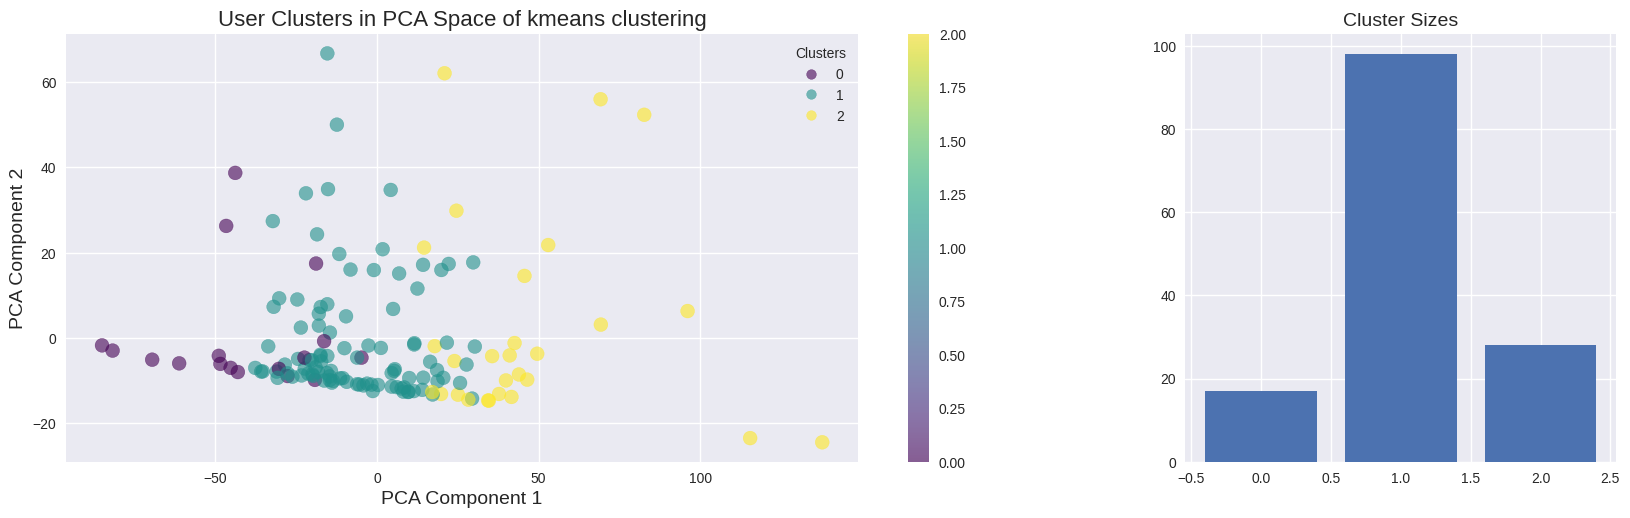

In [140]:
plot_clustering_results('kmeans', clusters, df_clustering_features)


In [141]:
df_clustering_features['kmeans_cluster'] = clusters['kmeans']

## Cluster Level Comparison

Total Activities Statistics by Cluster:
                     mean  median        std
kmeans_cluster                              
0                6.882353     0.0  14.203355
1                7.632653     3.0  10.666827
2               14.785714     7.5  17.229082

ANOVA Test: F-statistic = 3.759, p-value = 0.026
Kruskal-Wallis Test: H-statistic = 6.282, p-value = 0.043


Activity Diversity Index by Cluster:
                    mean  median       std
kmeans_cluster                            
0               0.034025     0.0  0.075166
1               0.104354     0.0  0.178641
2               0.107343     0.0  0.171007


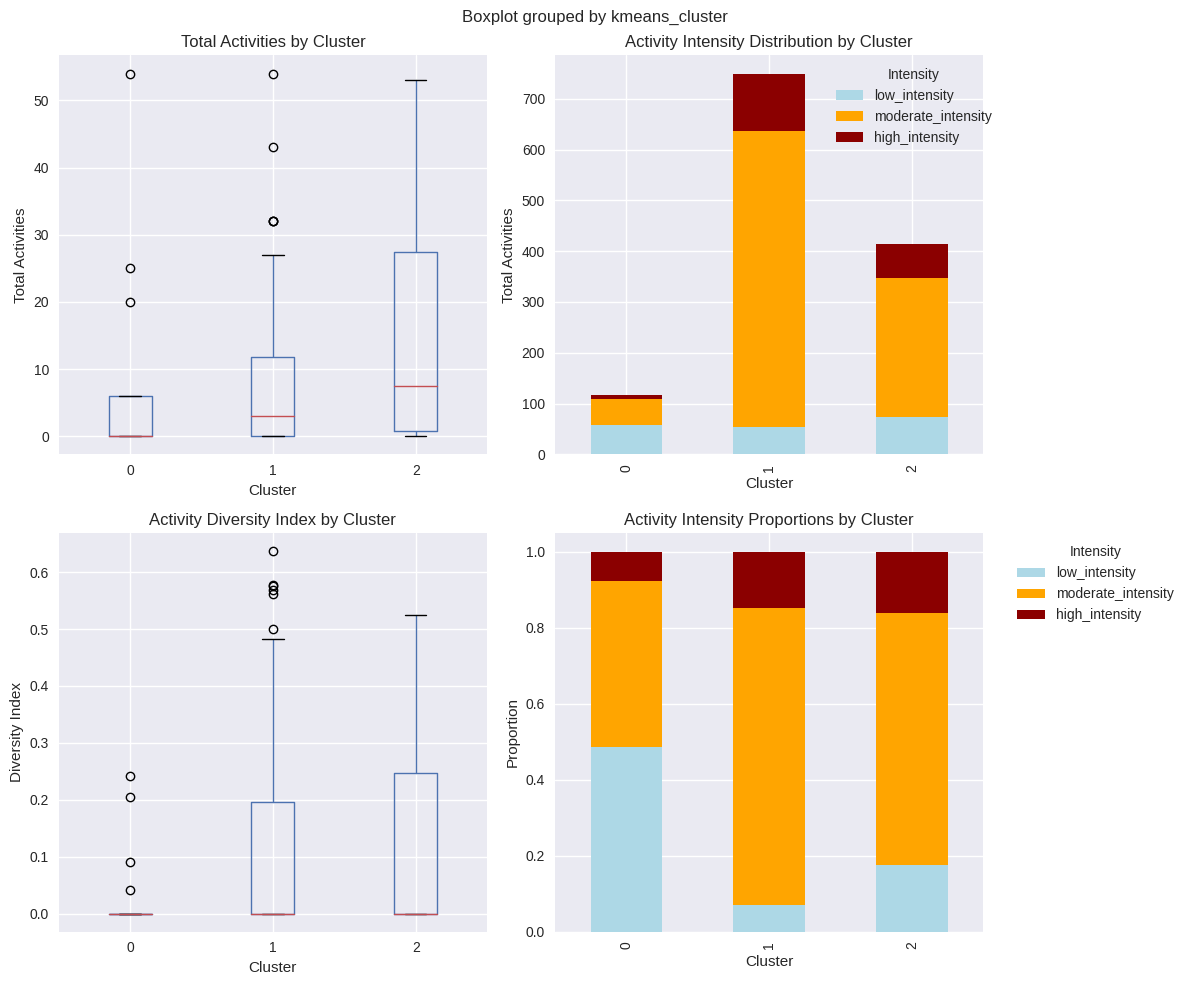



Cluster Activity Profiles:

Cluster 0:
  - Avg total activities: 6.9
  - Avg diversity index: 0.034
  - Moderate intensity %: 43.6%
  - High intensity %: 7.7%
  - Low intensity %: 48.7%

Cluster 1:
  - Avg total activities: 7.6
  - Avg diversity index: 0.104
  - Moderate intensity %: 78.1%
  - High intensity %: 14.8%
  - Low intensity %: 7.1%

Cluster 2:
  - Avg total activities: 14.8
  - Avg diversity index: 0.107
  - Moderate intensity %: 66.2%
  - High intensity %: 16.2%
  - Low intensity %: 17.6%


In [144]:

# Set style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Total Activities by Cluster
ax1 = axes[0, 0]
df_clustering_features.boxplot(column='total_activities', by='kmeans_cluster', ax=ax1)
ax1.set_title('Total Activities by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Total Activities')

# Mean/Median comparison
activity_stats = df_clustering_features.groupby('kmeans_cluster')['total_activities'].agg(['mean', 'median', 'std'])
print("Total Activities Statistics by Cluster:")
print(activity_stats)

# Statistical tests
groups = [group['total_activities'].values for name, group in df_clustering_features.groupby('kmeans_cluster')]
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nANOVA Test: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")

kruskal_stat, kruskal_p = stats.kruskal(*groups)
print(f"Kruskal-Wallis Test: H-statistic = {kruskal_stat:.3f}, p-value = {kruskal_p:.3f}")

# 2. Activity Intensity Distribution
ax2 = axes[0, 1]
intensity_cols = ['low_intensity', 'moderate_intensity', 'high_intensity']
intensity_data = df_clustering_features.groupby('kmeans_cluster')[intensity_cols].sum()
intensity_data.plot(kind='bar', stacked=True, ax=ax2, color=['lightblue', 'orange', 'darkred'])
ax2.set_title('Activity Intensity Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Total Activities')
ax2.legend(title='Intensity', bbox_to_anchor=(1.05, 1))

# 3. Activity Diversity Index
ax3 = axes[1, 0]
df_clustering_features.boxplot(column='diversity_index', by='kmeans_cluster', ax=ax3)
ax3.set_title('Activity Diversity Index by Cluster')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Diversity Index')

# Diversity statistics
diversity_stats = df_clustering_features.groupby('kmeans_cluster')['diversity_index'].agg(['mean', 'median', 'std'])
print("\n\nActivity Diversity Index by Cluster:")
print(diversity_stats)

# 4. Intensity Proportions
ax4 = axes[1, 1]
intensity_props = intensity_data.div(intensity_data.sum(axis=1), axis=0)
intensity_props.plot(kind='bar', stacked=True, ax=ax4, color=['lightblue', 'orange', 'darkred'])
ax4.set_title('Activity Intensity Proportions by Cluster')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Proportion')
ax4.legend(title='Intensity', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Summary interpretation
print("\n\nCluster Activity Profiles:")
for cluster in sorted(df_clustering_features['kmeans_cluster'].unique()):
    cluster_data = df_clustering_features[df_clustering_features['kmeans_cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  - Avg total activities: {cluster_data['total_activities'].mean():.1f}")
    print(f"  - Avg diversity index: {cluster_data['diversity_index'].mean():.3f}")
    print(f"  - Moderate intensity %: {(cluster_data['moderate_intensity'].sum() / cluster_data[intensity_cols].sum().sum() * 100):.1f}%")
    print(f"  - High intensity %: {(cluster_data['high_intensity'].sum() / cluster_data[intensity_cols].sum().sum() * 100):.1f}%")
    print(f"  - Low intensity %: {(cluster_data['low_intensity'].sum() / cluster_data[intensity_cols].sum().sum() * 100):.1f}%")


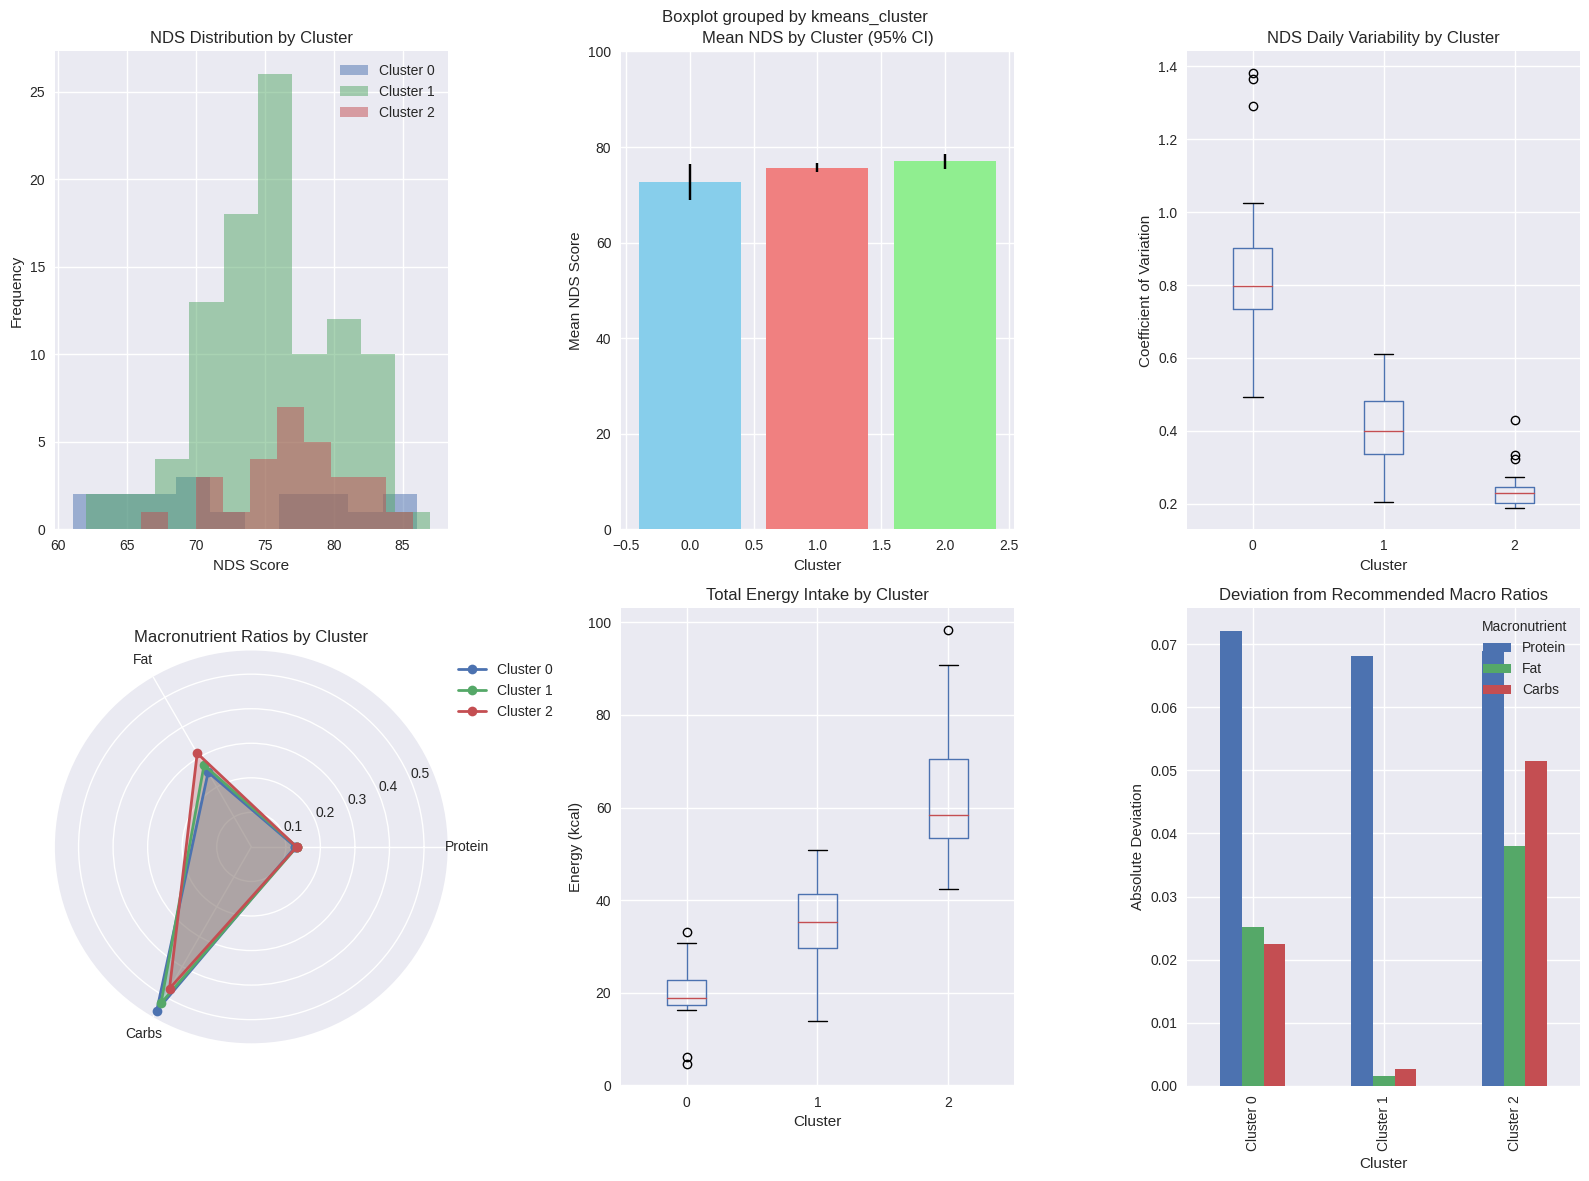

NDS Statistics by Cluster:
                     mean       std
kmeans_cluster                     
0               72.670792  7.866265
1               75.652430  4.811404
2               77.009571  4.423981


Macronutrient Ratios by Cluster:
                macro_ratios_protein_ratio  macro_ratios_fat_ratio  \
kmeans_cluster                                                       
0                                 0.127877                0.249817   
1                                 0.131811                0.273454   
2                                 0.131162                0.313002   

                macro_ratios_carb_ratio  
kmeans_cluster                           
0                              0.547492  
1                              0.522258  
2                              0.473450  


Energy Intake Statistics:
                     mean     median        std
kmeans_cluster                                 
0               19.659547  18.871736   7.420120
1               35.272182

In [ ]:
# Set style
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(16, 12))

# 1. NDS Distribution by Cluster
ax1 = plt.subplot(2, 3, 1)
for cluster in sorted(df_clustering_features['kmeans_cluster'].unique()):
    cluster_data = df_clustering_features[df_clustering_features['kmeans_cluster'] == cluster]['NDS_user_mean']
    ax1.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}', bins=10)
ax1.set_xlabel('NDS Score')
ax1.set_ylabel('Frequency')
ax1.set_title('NDS Distribution by Cluster')
ax1.legend()

# 2. Mean NDS with Confidence Intervals
ax2 = plt.subplot(2, 3, 2)
nds_stats = df_clustering_features.groupby('kmeans_cluster')['NDS_user_mean'].agg(['mean', 'std', 'count'])
nds_stats['ci'] = 1.96 * nds_stats['std'] / np.sqrt(nds_stats['count'])
x = nds_stats.index
ax2.bar(x, nds_stats['mean'], yerr=nds_stats['ci'], capsize=10, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Mean NDS Score')
ax2.set_title('Mean NDS by Cluster (95% CI)')
ax2.set_ylim(0, 100)

# 3. NDS Daily Variability (CV)
ax3 = plt.subplot(2, 3, 3)
df_clustering_features.boxplot(column='NDS_daily_cv', by='kmeans_cluster', ax=ax3)
ax3.set_title('NDS Daily Variability by Cluster')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Coefficient of Variation')

# 4. Radar Chart for Macro Ratios
ax4 = plt.subplot(2, 3, 4, projection='polar')
macro_cols = ['macro_ratios_protein_ratio', 'macro_ratios_fat_ratio', 'macro_ratios_carb_ratio']
macro_means = df_clustering_features.groupby('kmeans_cluster')[macro_cols].mean()

categories = ['Protein', 'Fat', 'Carbs']
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

for idx, cluster in enumerate(macro_means.index):
    values = macro_means.loc[cluster].tolist()
    values += values[:1]
    ax4.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}')
    ax4.fill(angles, values, alpha=0.25)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories)
ax4.set_title('Macronutrient Ratios by Cluster')
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 5. Energy Intake Patterns
ax5 = plt.subplot(2, 3, 5)
df_clustering_features.boxplot(column='avg_macros_energy_gain', by='kmeans_cluster', ax=ax5)
ax5.set_title('Total Energy Intake by Cluster')
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Energy (kcal)')

# 6. Deviation from Recommended Ratios
ax6 = plt.subplot(2, 3, 6)
# Recommended ratios (example: protein 15-25%, fat 20-35%, carbs 45-65%)
recommended = {'protein': 0.20, 'fat': 0.275, 'carbs': 0.525}
deviations = pd.DataFrame()

for cluster in sorted(df_clustering_features['kmeans_cluster'].unique()):
    cluster_means = df_clustering_features[df_clustering_features['kmeans_cluster'] == cluster][
        ['macro_ratios_protein_ratio', 'macro_ratios_fat_ratio', 'macro_ratios_carb_ratio']].mean()
    
    dev = {
        'Protein': abs(cluster_means['macro_ratios_protein_ratio'] - recommended['protein']),
        'Fat': abs(cluster_means['macro_ratios_fat_ratio'] - recommended['fat']),
        'Carbs': abs(cluster_means['macro_ratios_carb_ratio'] - recommended['carbs'])
    }
    deviations[f'Cluster {cluster}'] = dev

deviations.T.plot(kind='bar', ax=ax6)
ax6.set_title('Deviation from Recommended Macro Ratios')
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Absolute Deviation')
ax6.legend(title='Macronutrient')

plt.tight_layout()
plt.show()

# Statistical Summary
print("NDS Statistics by Cluster:")
print(nds_stats[['mean', 'std']])

print("\n\nMacronutrient Ratios by Cluster:")
print(macro_means)

print("\n\nEnergy Intake Statistics:")
energy_stats = df_clustering_features.groupby('kmeans_cluster')['avg_macros_energy_gain'].agg(['mean', 'median', 'std'])
print(energy_stats)

# ANOVA test for NDS differences
groups = [group['NDS_user_mean'].values for name, group in df_clustering_features.groupby('kmeans_cluster')]
f_stat, p_value = stats.f_oneway(*groups)
print(f"\n\nNDS ANOVA Test: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")

# Cluster Nutritional Profiles
print("\n\nCluster Nutritional Profiles:")
for cluster in sorted(df_clustering_features['kmeans_cluster'].unique()):
    cluster_data = df_clustering_features[df_clustering_features['kmeans_cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  - Avg NDS: {cluster_data['NDS_user_mean'].mean():.1f}")
    print(f"  - NDS variability (CV): {cluster_data['NDS_daily_cv'].mean():.3f}")
    print(f"  - Avg energy: {cluster_data['avg_macros_energy_gain'].mean():.0f} kcal")
    print(f"  - Protein/Fat/Carb: {cluster_data['macro_ratios_protein_ratio'].mean():.1%}/{cluster_data['macro_ratios_fat_ratio'].mean():.1%}/{cluster_data['macro_ratios_carb_ratio'].mean():.1%}")

In [149]:
merged_cluster = df.merge(df_clustering_features[['id', 'kmeans_cluster']], on='id', how='right')

In [150]:
merged_cluster.head()

,id,date_time,social_date,mood,sleep,energy_gain,water_gain,protein_gain,fat_gain,carb_gain,...,nationality,department,cohort,degree,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,kmeans_cluster
0,0.0,Evening,2020-11-12 19:00:00,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Kazakh,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,1
1,0.0,Evening,2020-11-12 19:30:00,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Kazakh,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,1
2,0.0,Night Time,2020-11-12 20:00:00,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Kazakh,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,1
3,0.0,Night Time,2020-11-12 20:30:00,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Kazakh,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,1
4,0.0,Night Time,2020-11-12 21:00:00,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,Kazakh,Engineering and Applied Sciences,24,MSc,68.75,87.5,93.75,50.0,87.5,1


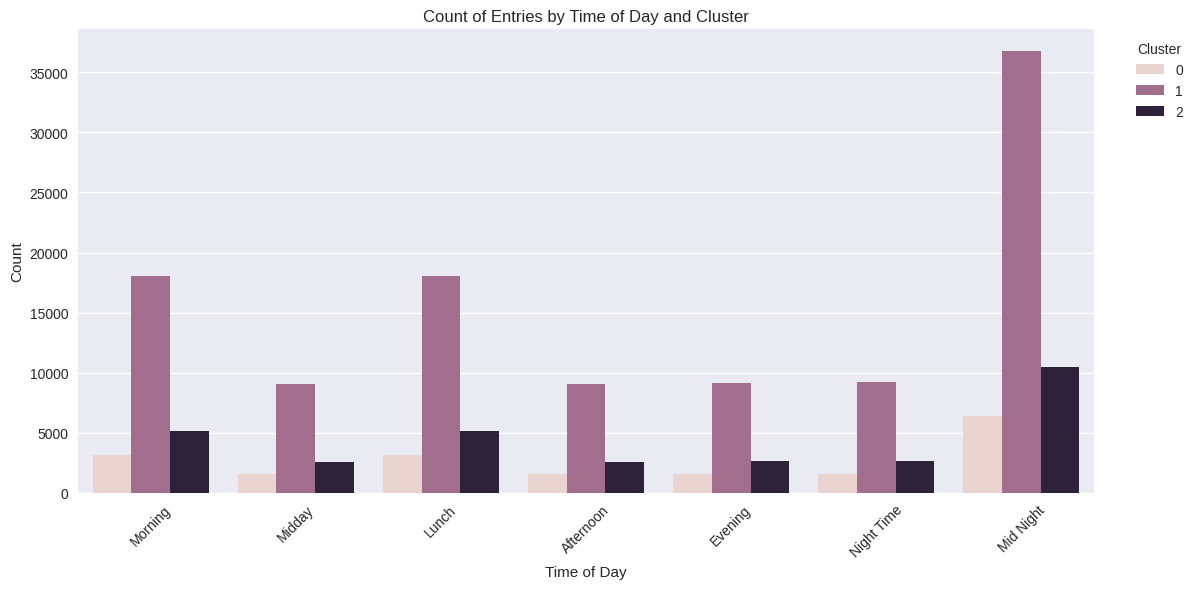

In [151]:

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=merged_cluster,
    x='date_time',
    hue='kmeans_cluster',
    order=['Morning','Midday','Lunch', 'Afternoon', 'Evening', 'Night Time', 'Mid Night']  # Custom order if needed
)

# Add labels and title
plt.title('Count of Entries by Time of Day and Cluster')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.1, 1))

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

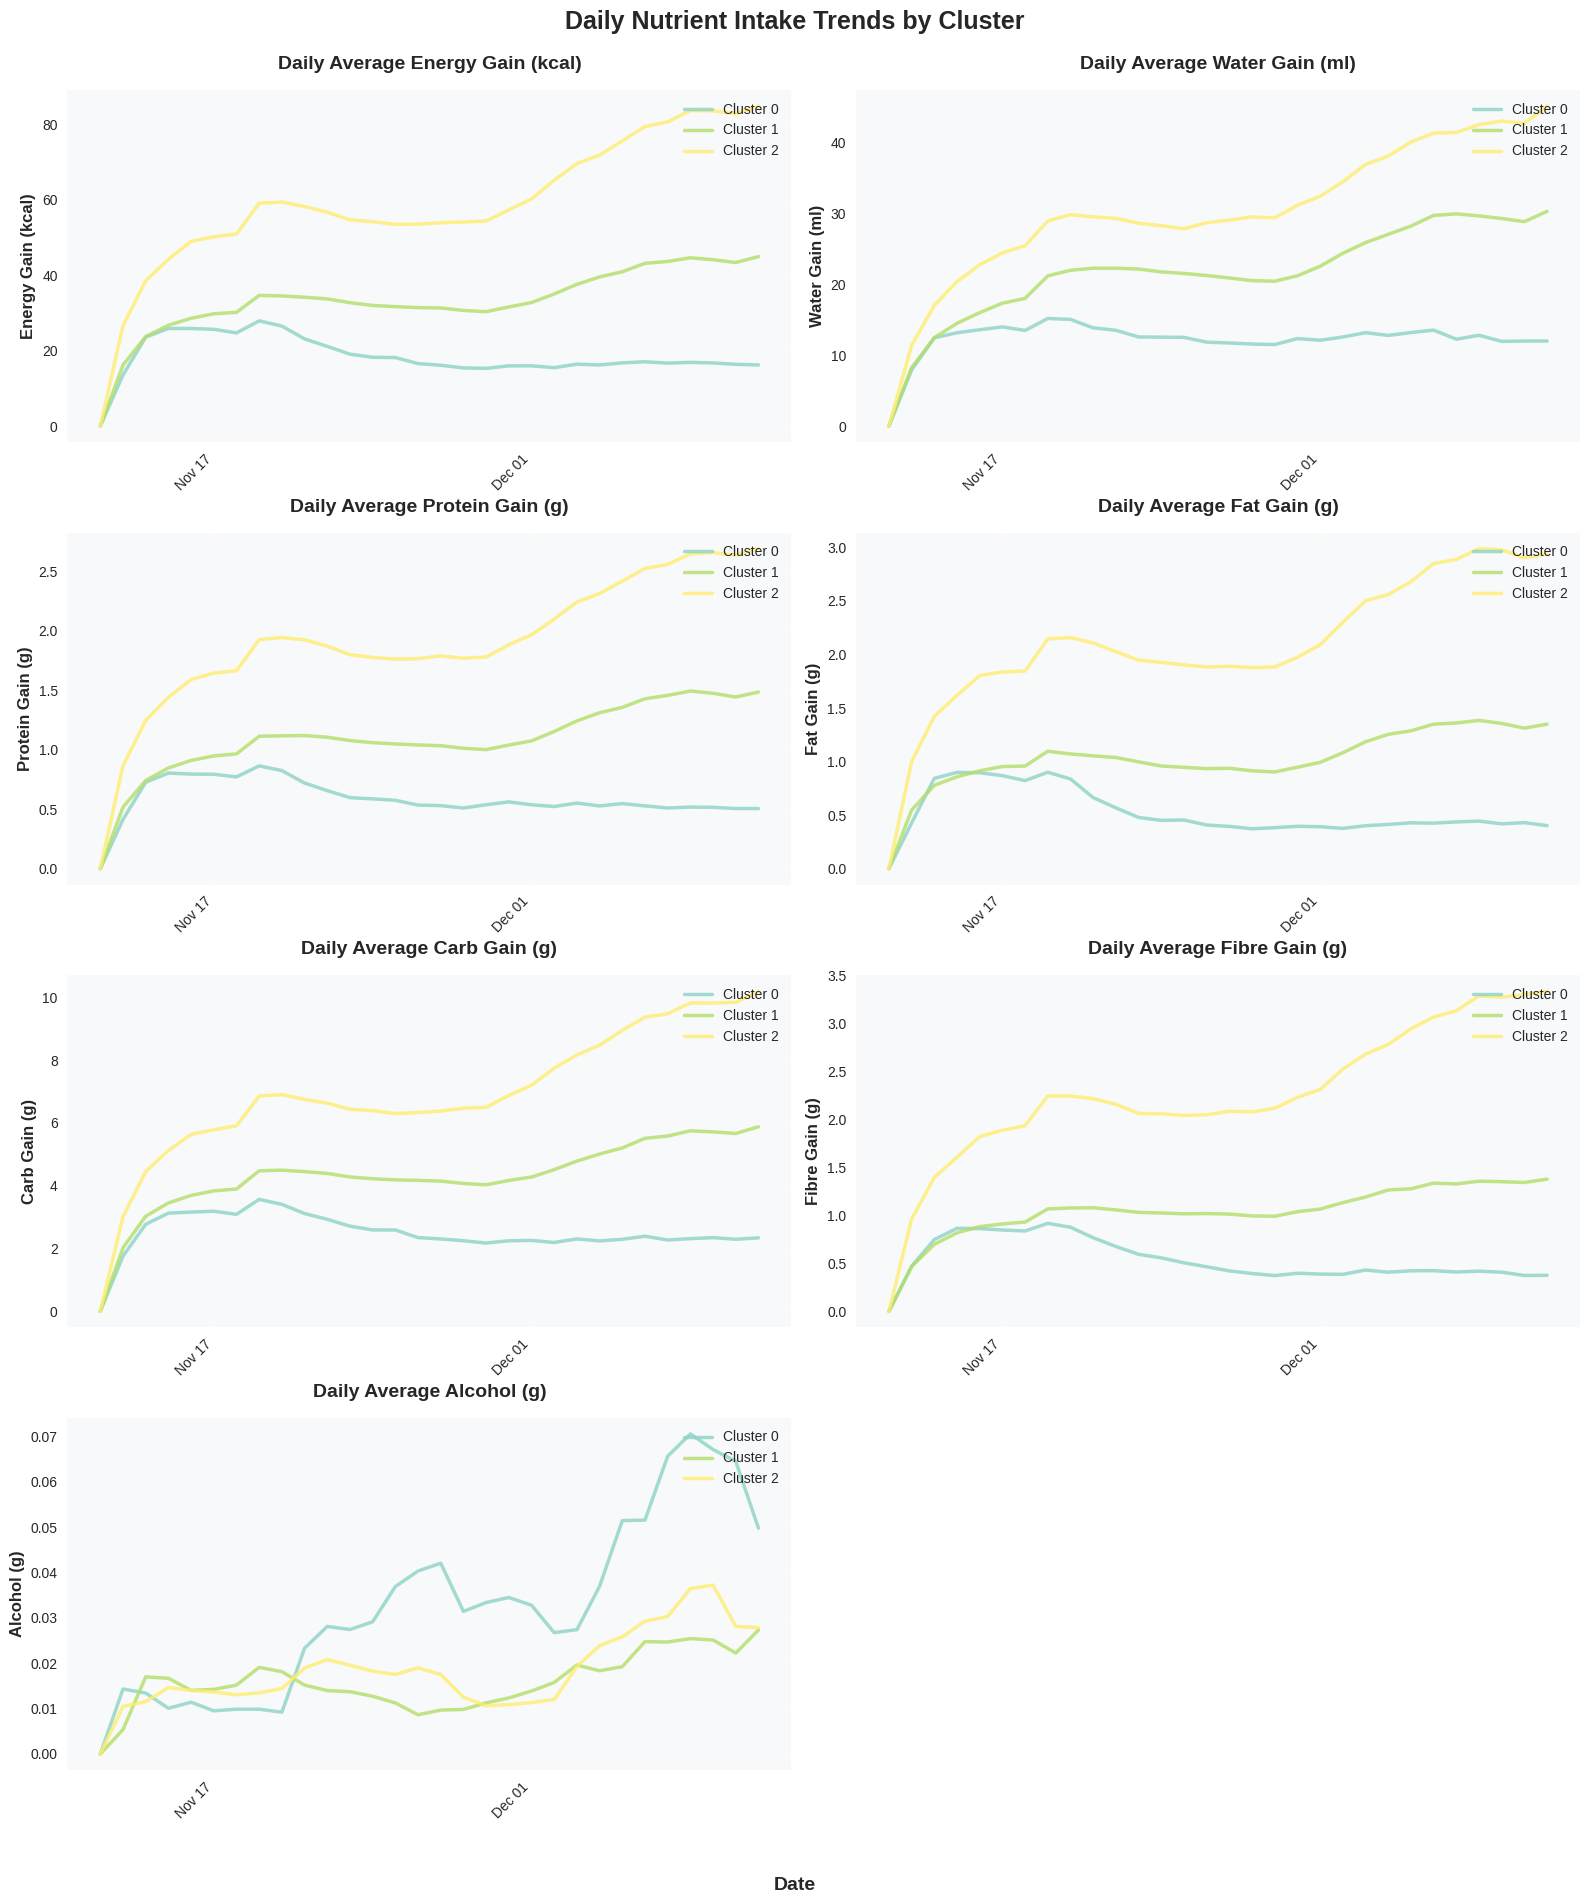

In [ ]:
# Ensure social_date is in datetime format
merged_cluster['social_date'] = pd.to_datetime(merged_cluster['social_date'])

# Set social_date as index for resampling
merged_cluster.set_index('social_date', inplace=True)

# Nutrients to plot with display names
nutrients = {
    'energy_gain': 'Energy Gain (kcal)',
    'water_gain': 'Water Gain (ml)',
    'protein_gain': 'Protein Gain (g)',
    'fat_gain': 'Fat Gain (g)',
    'carb_gain': 'Carb Gain (g)',
    'fibre_gain': 'Fibre Gain (g)',
    'alcohol': 'Alcohol (g)'
}

# Get unique clusters and sort them
clusters = sorted(merged_cluster['kmeans_cluster'].unique())

# Create a color palette for clusters
colors = plt.cm.Set3(np.linspace(0, 1, len(clusters)))

# Calculate the number of rows needed (2 plots per row)
n_nutrients = len(nutrients)
n_rows = (n_nutrients + 1) // 2  # +1 to round up

# Create figure with subplots arranged in 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each nutrient
for i, (nutrient_key, nutrient_name) in enumerate(nutrients.items()):
    ax = axes[i]
    
    # For each cluster, resample and plot
    for j, cluster in enumerate(clusters):
        # Filter data for this cluster
        cluster_data = merged_cluster[merged_cluster['kmeans_cluster'] == cluster]

        # Resample to daily mean
        daily_means = cluster_data[nutrient_key].resample('D').mean()
        
        # Calculate rolling average for smoother lines
        smoothed_means = daily_means.rolling(window=7, min_periods=1).mean()

        # Plot with a label
        ax.plot(smoothed_means.index, smoothed_means.values, 
                label=f'Cluster {cluster}', linewidth=2.5, color=colors[j],
                alpha=0.8)
    
    # Customize the subplot
    ax.set_title(f'Daily Average {nutrient_name}', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel(nutrient_name, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis to show dates properly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Remove spines for a cleaner look
    ax.spines[['top', 'right']].set_visible(False)
    
    # Add a light background for better readability
    ax.set_facecolor('#f8f9fa')

# Hide any unused subplots
for i in range(n_nutrients, len(axes)):
    fig.delaxes(axes[i])

# Add a common x-label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=14, fontweight='bold')

# Add a title for the entire figure
plt.suptitle('Daily Nutrient Intake Trends by Cluster', fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.94)
plt.show()

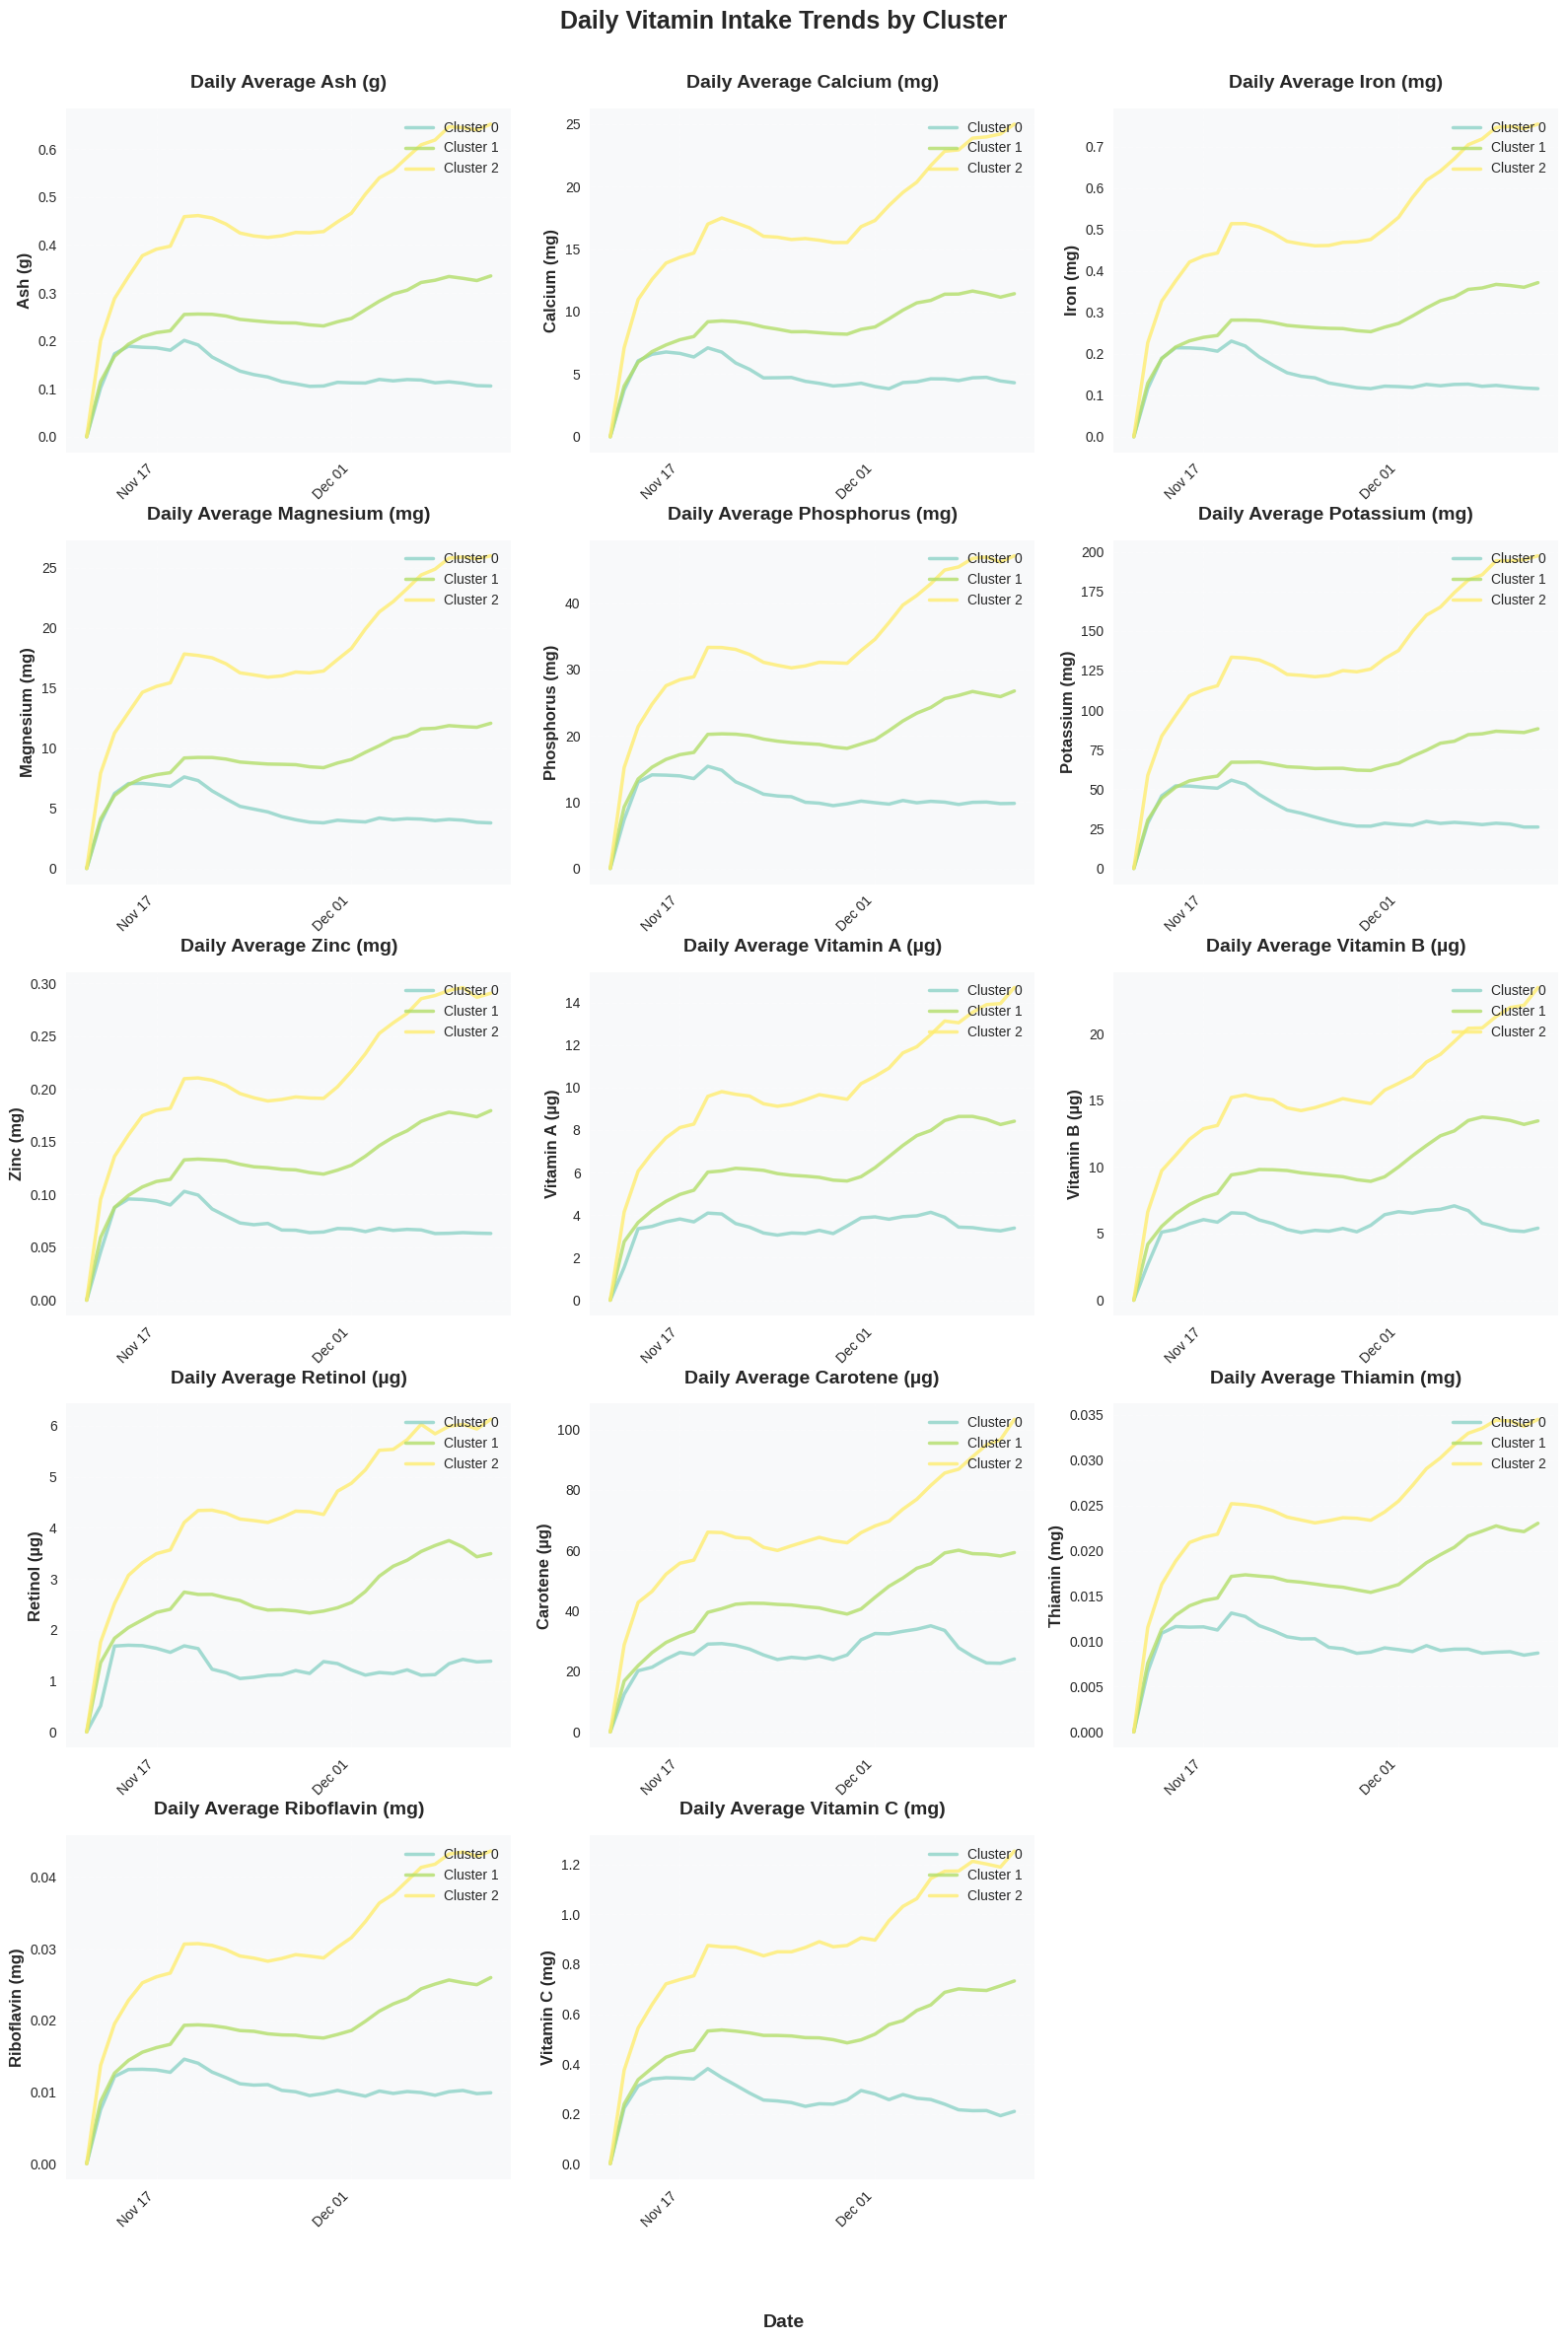

In [153]:
# Nutrients to plot with display names
nutrients = {
    'ash': 'Ash (g)',
    'calcium': 'Calcium (mg)',
    'iron': 'Iron (mg)',
    'magnesium': 'Magnesium (mg)',
    'phosphorus': 'Phosphorus (mg)',
    'potassium': 'Potassium (mg)',
    'zinc': 'Zinc (mg)',
    'vitamin_A': 'Vitamin A (µg)',
    'vitamin_B': 'Vitamin B (µg)',
    'retinol': 'Retinol (µg)',
    'carotene': 'Carotene (µg)',
    'thiamin': 'Thiamin (mg)',
    'riboflavin': 'Riboflavin (mg)',
    'vitamin_C': 'Vitamin C (mg)',

}

# Get unique clusters and sort them
clusters = sorted(merged_cluster['kmeans_cluster'].unique())

# Create a color palette for clusters
colors = plt.cm.Set3(np.linspace(0, 1, len(clusters)))

# Calculate the number of rows needed (2 plots per row)
n_nutrients = len(nutrients)
n_rows = (n_nutrients + 1) // 3  # +1 to round up

# Create figure with subplots arranged in 2 columns
fig, axes = plt.subplots(n_rows, 3, figsize=(16, 5 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each nutrient
for i, (nutrient_key, nutrient_name) in enumerate(nutrients.items()):
    ax = axes[i]
    
    # For each cluster, resample and plot
    for j, cluster in enumerate(clusters):
        # Filter data for this cluster
        cluster_data = merged_cluster[merged_cluster['kmeans_cluster'] == cluster]

        # Resample to daily mean
        daily_means = cluster_data[nutrient_key].resample('D').mean()
        
        # Calculate rolling average for smoother lines
        smoothed_means = daily_means.rolling(window=7, min_periods=1).mean()

        # Plot with a label
        ax.plot(smoothed_means.index, smoothed_means.values, 
                label=f'Cluster {cluster}', linewidth=2.5, color=colors[j],
                alpha=0.8)
    
    # Customize the subplot
    ax.set_title(f'Daily Average {nutrient_name}', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel(nutrient_name, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis to show dates properly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Remove spines for a cleaner look
    ax.spines[['top', 'right']].set_visible(False)
    
    # Add a light background for better readability
    ax.set_facecolor('#f8f9fa')

# Hide any unused subplots
for i in range(n_nutrients, len(axes)):
    fig.delaxes(axes[i])

# Add a common x-label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=14, fontweight='bold')

# Add a title for the entire figure
plt.suptitle('Daily Vitamin Intake Trends by Cluster', fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.94)
plt.show()

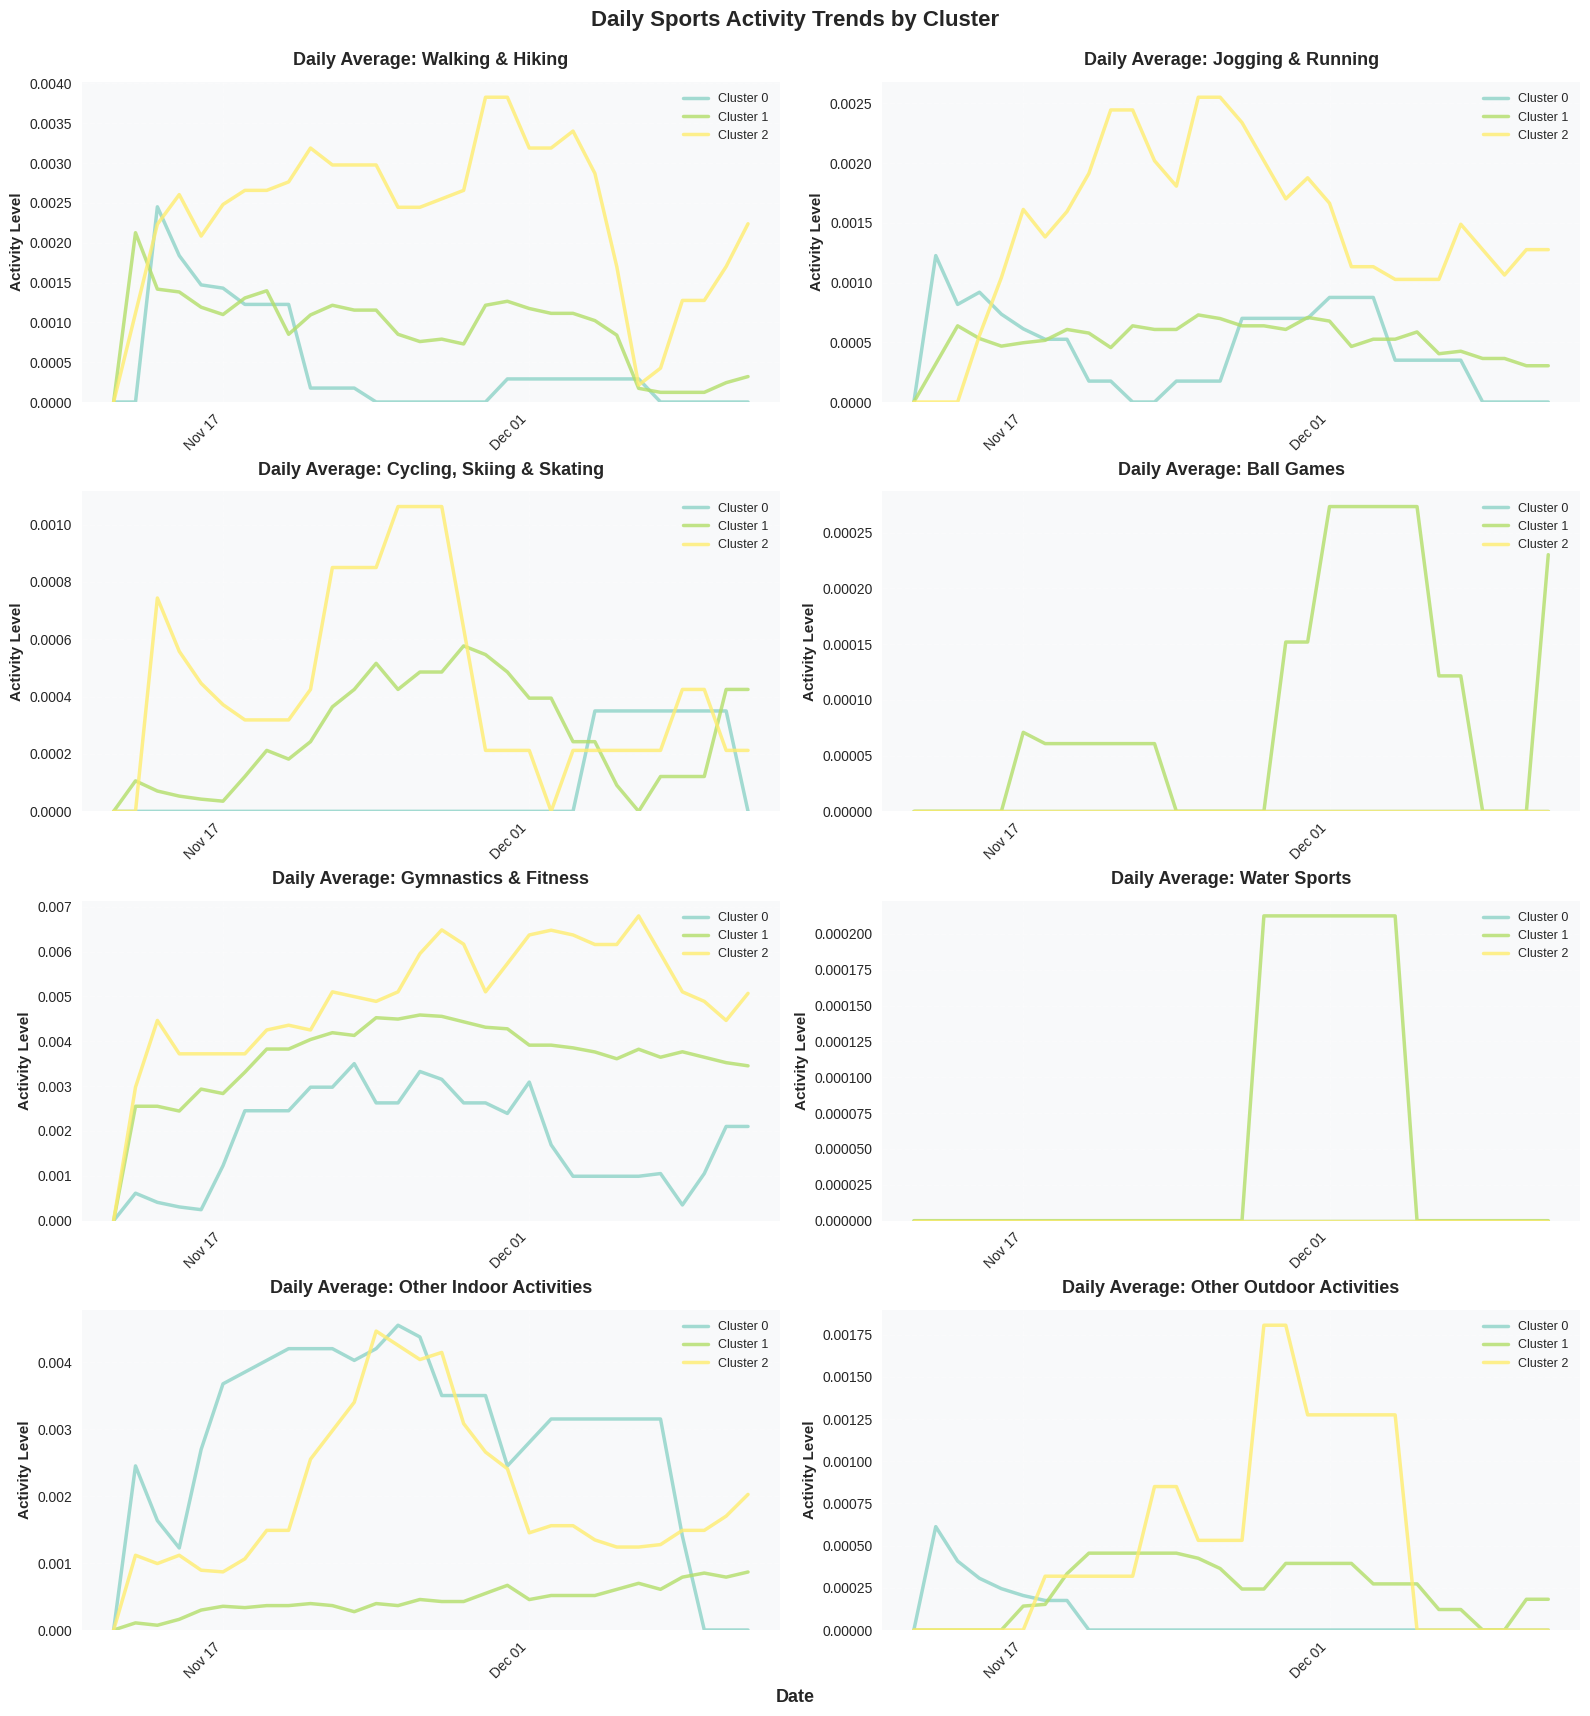

In [154]:


# Sports activities to plot with better display names
sports_activities = {
    'sport_Walking, Trekking, and hiking': 'Walking & Hiking',
    'sport_Jogging and running': 'Jogging & Running',
    'sport_Cycling, skiing, and skating': 'Cycling, Skiing & Skating',
    'sport_Ball games': 'Ball Games',
    'sport_Gymnastics and fitness': 'Gymnastics & Fitness',
    'sport_Water sports': 'Water Sports',
    'sport_Other indoor activities': 'Other Indoor Activities',
    'sport_Other outdoor activities': 'Other Outdoor Activities'
}

# Get unique clusters and sort them
clusters = sorted(merged_cluster['kmeans_cluster'].unique())

# Create a color palette for clusters
colors = plt.cm.Set3(np.linspace(0, 1, len(clusters)))

# Calculate the number of rows needed (2 plots per row)
n_activities = len(sports_activities)
n_rows = (n_activities + 1) // 2  # +1 to round up

# Create figure with subplots arranged in 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 4.5 * n_rows))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each sports activity
for i, (activity_key, activity_name) in enumerate(sports_activities.items()):
    ax = axes[i]
    
    # For each cluster, resample and plot
    for j, cluster in enumerate(clusters):
        # Filter data for this cluster
        cluster_data = merged_cluster[merged_cluster['kmeans_cluster'] == cluster]

        # Resample to daily mean
        daily_means = cluster_data[activity_key].resample('D').mean()
        
        # Calculate rolling average for smoother lines (7-day window)
        smoothed_means = daily_means.rolling(window=7, min_periods=1).mean()

        # Plot with a label
        ax.plot(smoothed_means.index, smoothed_means.values, 
                label=f'Cluster {cluster}', linewidth=2.5, color=colors[j],
                alpha=0.8)
    
    # Customize the subplot
    ax.set_title(f'Daily Average: {activity_name}', fontsize=13, fontweight='bold', pad=12)
    ax.set_ylabel('Activity Level', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis to show dates properly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Remove spines for a cleaner look
    ax.spines[['top', 'right']].set_visible(False)
    
    # Add a light background for better readability
    ax.set_facecolor('#f8f9fa')
    
    # Set y-axis to start from 0 for better comparison
    ax.set_ylim(bottom=0)

# Hide any unused subplots
for i in range(n_activities, len(axes)):
    fig.delaxes(axes[i])

# Add a common x-label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=13, fontweight='bold')

# Add a title for the entire figure
plt.suptitle('Daily Sports Activity Trends by Cluster', fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08, top=0.94)
plt.show()

## Save

In [155]:
df_clustering_features.to_csv('data/user_cluster_final.csv', index=False, sep=';')